In this code, I want to compare slope constrained and linear spline model. for the former, i will set the same grid which i will use for the latter. thus both the models would be equivalent and ideally should behave the same!

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, Dataset

from activations.linearspline_slope_constraint import LinearSplineSlopeConstrained
from activations.linearspline import LinearSpline

import os
import json
from tqdm import tqdm

# dataset (2 moons)
from sklearn.datasets import make_moons


import torch.optim as optim
from torch.nn.utils import clip_grad_norm_

In [2]:
# Function to generate data from a 1D Gaussian distribution
def generate_gaussian_data(mean, 
            std_dev, total_samples, train_ratio=0.7, val_ratio=0.15):
    """
    Generate training, validation, and test datasets from a 1D Gaussian distribution.

    Parameters:
    - mean: Mean of the Gaussian distribution
    - std_dev: Standard deviation of the Gaussian distribution
    - total_samples: Total number of samples to generate
    - train_ratio: Proportion of data to use for training (default is 70%)
    - val_ratio: Proportion of data to use for validation (default is 15%)

    Returns:
    - train_data: Training set
    - val_data: Validation set
    - test_data: Test set
    """
    # Generate data
    data = np.random.normal(loc=mean, scale=std_dev, size=total_samples)

    # Shuffle data
    np.random.shuffle(data)

    # Split data based on ratios
    train_end = int(total_samples * train_ratio)
    val_end = train_end + int(total_samples * val_ratio)

    train_data = data[:train_end]
    val_data = data[train_end:val_end]
    test_data = data[val_end:]

    return train_data, val_data, test_data

# Function to convert datasets into DataLoaders
def create_dataloaders(train_data, val_data, test_data, batch_size=32):
    """
    Convert numpy arrays into PyTorch DataLoaders.

    Parameters:
    - train_data: Training dataset (numpy array)
    - val_data: Validation dataset (numpy array)
    - test_data: Test dataset (numpy array)
    - batch_size: Batch size for the DataLoaders

    Returns:
    - train_loader: DataLoader for training data
    - val_loader: DataLoader for validation data
    - test_loader: DataLoader for test data
    """
    # Convert numpy arrays to PyTorch tensors
    train_tensor = torch.tensor(train_data, dtype=torch.float32)
    val_tensor = torch.tensor(val_data, dtype=torch.float32)
    test_tensor = torch.tensor(test_data, dtype=torch.float32)

    # Create TensorDatasets
    train_dataset = TensorDataset(train_tensor)
    val_dataset = TensorDataset(val_tensor)
    test_dataset = TensorDataset(test_tensor)

    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader





In [3]:
# Function to generate data from a 1D Laplace distribution
def generate_laplace_data(mean, scale, total_samples, train_ratio=0.7, val_ratio=0.15):
    """
    Generate training, validation, and test datasets from a 1D Laplace distribution.

    Parameters:
    - mean: Mean (location parameter) of the Laplace distribution
    - scale: Scale (diversity) parameter of the Laplace distribution
    - total_samples: Total number of samples to generate
    - train_ratio: Proportion of data to use for training (default is 70%)
    - val_ratio: Proportion of data to use for validation (default is 15%)

    Returns:
    - train_data: Training set
    - val_data: Validation set
    - test_data: Test set
    """
    # Generate data
    data = np.random.laplace(loc=mean, scale=scale, size=total_samples)

    # Shuffle data
    np.random.shuffle(data)

    # Split data based on ratios
    train_end = int(total_samples * train_ratio)
    val_end = train_end + int(total_samples * val_ratio)

    train_data = data[:train_end]
    val_data = data[train_end:val_end]
    test_data = data[val_end:]

    return train_data, val_data, test_data




In [4]:
# GENERATE GAUSSIAN DATA
# mean = 3.0#2
# std_dev = 3.0
# total_samples = 8000#50000

# train_data, val_data, test_data = generate_gaussian_data(mean, std_dev, total_samples)

# GENERATE LAPLACE DATA
mean = 5
scale = 6
total_samples = 30000
# for each minibatch, new data
#
train_data, val_data, test_data = generate_laplace_data(mean, scale, total_samples)
print(f"Train size: {len(train_data)}, Val size: {len(val_data)}, Test size: {len(test_data)}")


Train size: 21000, Val size: 4500, Test size: 4500


In [5]:
# Reshape data before returning
train_data = train_data.reshape(-1, 1)
val_data = val_data.reshape(-1, 1)
test_data = test_data.reshape(-1, 1)

# Convert to DataLoaders
batch_size = 20#16#32#16#16#32
train_loader, val_loader, test_loader = create_dataloaders(train_data, val_data, test_data, batch_size)

# Print dataset sizes
print(f"Training set size: {len(train_data)}")
print(f"Validation set size: {len(val_data)}")
print(f"Test set size: {len(test_data)}")

Training set size: 21000
Validation set size: 4500
Test set size: 4500


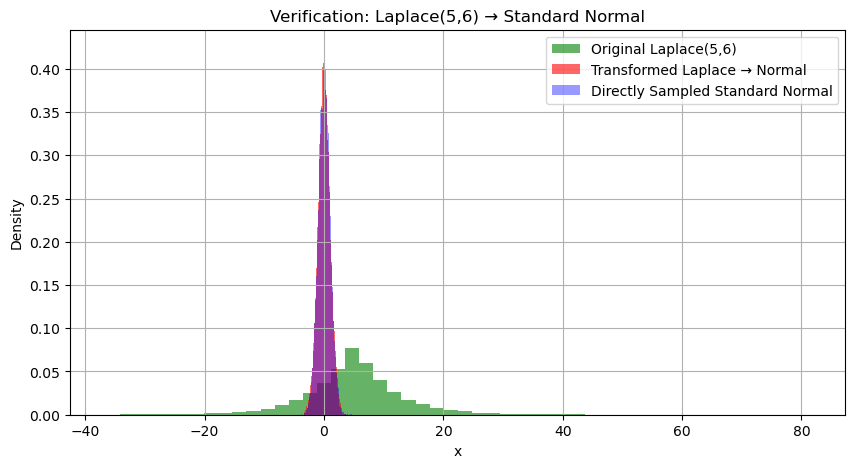

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, laplace

# Transformation function for Laplace(mu, b) → Standard Normal
def laplace_to_normal(x, mu=0, b=1):
    """
    Transforms a Laplace(mu, b) distributed variable into a standard normal.
    
    Args:
    - x: Input Laplace-distributed samples.
    - mu: Mean of the Laplace distribution.
    - b: Scale parameter of the Laplace distribution.
    
    Returns:
    - Transformed values following a standard normal distribution.
    """
    # Compute shifted & scaled Laplace CDF
    F_X = np.where(x < mu, 0.5 * np.exp((x - mu) / b), 1 - 0.5 * np.exp(-(x - mu) / b))
    # Apply inverse CDF of standard normal
    return norm.ppf(F_X)

# Step 1: Sample from a Laplace distribution with custom mean and scale
num_samples = 10000
mu, b = mean, scale  # Example: Laplace(2, 1.5)
laplace_samples = laplace.rvs(loc=mu, scale=b, size=num_samples)

# Step 2: Apply transformation
normal_samples_transformed = laplace_to_normal(laplace_samples, mu, b)

# Step 3: Sample directly from standard normal for comparison
normal_samples_direct = norm.rvs(size=num_samples)

# Step 4: Plot histograms before and after transformation
plt.figure(figsize=(10, 5))

# Original Laplace distribution before transformation
plt.hist(laplace_samples, bins=50, density=True, alpha=0.6, color='g', label=f'Original Laplace({mu},{b})')

# Transformed Laplace samples
plt.hist(normal_samples_transformed, bins=50, density=True, alpha=0.6, color='r', label='Transformed Laplace → Normal')

# Direct Standard Normal samples
plt.hist(normal_samples_direct, bins=50, density=True, alpha=0.4, color='b', label='Directly Sampled Standard Normal')

# Labels and legend
plt.title(f"Verification: Laplace({mu},{b}) → Standard Normal")
plt.xlabel("x")
plt.ylabel("Density")
plt.legend()
plt.grid()
plt.show()


In [7]:
from scipy.stats import norm



def transformation_laplace_to_std_normal(mu=0, b=1, x_range=(-10,10), num_points=41):
    # Define x values
    x = np.linspace(x_range[0], x_range[1], num_points)

    # Compute Laplace CDF
    F_X = np.where(x < mu, 0.5 * np.exp((x - mu) / b), 1 - 0.5 * np.exp(-(x - mu) / b))

    # Compute the transformation function T(x)
    T_x = norm.ppf(F_X)

    return x,T_x

def plot_transformation(mu=0, b=1, x_range=(-5, 5), num_points=1000):
    """
    Plots the transformation function T(x) = Φ⁻¹(F_X(x)) that maps a 
    Laplace(mu, b) distributed variable to a standard normal.
    
    Args: 
    - mu: Mean of the Laplace distribution.
    - b: Scale parameter of the Laplace distribution.
    - x_range: Tuple defining the range of x values for the plot.
    - num_points: Number of points in the plot.
    
    Returns:
    - A plot of T(x) = Φ⁻¹(F_X(x)).
    """
    x,T_x = transformation_laplace_to_std_normal(mu=mu, b=b, x_range=x_range, num_points=num_points)

    # Plot T(x)
    plt.figure(figsize=(7, 5))
    plt.plot(x, T_x, label=r'$T(x) = \Phi^{-1}(F_X(x))$', color='b')
    plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
    plt.axvline(0, color='black', linestyle='--', linewidth=0.8)
    plt.xlabel("$x$")
    plt.ylabel("$T(x)$")
    plt.title(f"Transformation Function from Laplace({mu}, {b}) to Standard Normal")
    plt.legend()
    plt.grid(which='both')  # Optional: Add a grid
    plt.minorticks_on()

    # Bold major grid lines
    plt.grid(which='major', linestyle='-', linewidth=1.5, alpha=0.9, color='black')

    # Light minor grid lines
    plt.grid(which='minor', linestyle=':', linewidth=0.7, alpha=0.5, color='gray')
    plt.show()


In [8]:
# Now i need to train this model using NLL loss
def nll_loss(z, det_jacobian, alpha_nll=1,return_indiv_loss=0):
    '''
    z :  tensor z in latent space
    det_jacobian : det(J_{f}(xi)) for each xi (we will take abs in this fn later)
    '''
    loss_1 = 0.5 * torch.sum(z**2)
    # print("det jacobian is:"); print(det_jacobian)
    #loss_2 = torch.sum(torch.log(torch.abs(det_jacobian)))
    loss_2 = torch.sum(torch.log(det_jacobian)) # coy slopes are always positive
    # print("torch.log(torch.abs(det_jacobian):",torch.log(torch.abs(det_jacobian)))
    # print(f"loss 1 is: {loss_1} and loss 2 is: {loss_2}")
    dataset_length = z.size(0)
    loss_with_alpha = (loss_1-loss_2)/ dataset_length # earlier i have some multiplicative alpha here but i removed it as we dont need it
    loss_normal = (loss_1 - loss_2)/ dataset_length
    if return_indiv_loss:
        return loss_with_alpha, loss_normal,loss_1/dataset_length, loss_2/dataset_length
    return loss_with_alpha, loss_normal

In [9]:
def plot_multiple_histogram(list_of_inputs, labels_list):
    # add a code line here: if the inputs are not numpy, convert them to numpy
    plt.figure(figsize=(5, 5))

    for i in range(0,len(list_of_inputs)):
        # Histogram for the code samples
        plt.hist(list_of_inputs[i], bins=50, alpha=0.4, 
                density=True, label=labels_list[i])
        plt.legend()

In [10]:
# plot splines with annotations
def plot_with_annotations(x, y,label="with const coeffs",
                title="Plot with (x, y) Annotations", 
            xlabel="X-axis", ylabel="Y-axis",
            txt_color="red", annotate=1, style="-o"):
    """
    Plot x and y values with (x, y) annotations.

    Args:
    - x (array-like): Array of x-values.
    - y (array-like): Array of y-values.
    - title (str): Title of the plot.
    - xlabel (str): Label for the X-axis.
    - ylabel (str): Label for the Y-axis.

    Returns:
    - None
    """
    plt.plot(x, y, style,label=label)  # Plot the points with markers and lines

    # Annotate each point with its (x, y) coordinates
    if annotate:
        for x_val, y_val in zip(x, y):
            plt.annotate(
                f"({x_val:.2f}, {y_val:.2f})",  # Format to 2 decimal places
                (x_val, y_val),  # The point to annotate
                textcoords="offset points",  # Offset the text slightly
                xytext=(5, 5),  # Offset (5, 5) pixels
                fontsize=8,  # Font size of the annotation
                color=txt_color # Optional: text color
            )
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(which='both')  # Optional: Add a grid
    plt.minorticks_on()

    # Define x values
    x = np.linspace(-40, 40, 1000)

    # Compute Laplace CDF
    F_X = np.where(x < mu, 0.5 * np.exp((x - mu) / b), 1 - 0.5 * np.exp(-(x - mu) / b))

    # Compute the transformation function T(x)
    T_x = norm.ppf(F_X)

    # Plot T(x)
    plt.plot(x, T_x, label=r'$T(x) = \Phi^{-1}(F_X(x))$', color='b')

    # Bold major grid lines
    plt.grid(which='major', linestyle='-', linewidth=1.5, alpha=0.9, color='black')

    # Light minor grid lines
    plt.grid(which='minor', linestyle=':', linewidth=0.7, alpha=0.5, color='gray')
    plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
    plt.axvline(0, color='black', linestyle='--', linewidth=0.8)
    plt.legend()

In [11]:
def TV2(model, device_info):
    """
    Computes the sum of the TV(2) (second-order total-variation)
    semi-norm of all linearspline activations in the network.

    Returns:
        tv2 (0d Tensor):
            tv2 = sum(TV(2))
    """
    tv2 = torch.Tensor([0.]).to(device_info)

    for module in model.modules():
        if isinstance(module, LinearSplineSlopeConstrained):
            module_tv2 = module.totalVariation(mode='additive')
            tv2 = tv2 + module_tv2.norm(p=1)
    # print("tv2 is:"); print(tv2)

    return tv2[0] 

In [12]:
# train and evaluate fn.
def train_and_evaluate(
    model, train_loader, val_loader, 
    lambda_tv2=1e-4, num_epochs=10, 
    lr=0.001, print_after=1, tv2_regulation=False, 
    scheduler_type="StepLR", step_size=5, gamma=0.1,
    alpha_nll=1,
    track_coefficients = False, type_model="ls"#"scls"
):
    """
    Train the RealNVP model and evaluate on a validation dataset.

    Args:
    - model: The NF model to be trained.
    - train_loader (DataLoader): DataLoader for the training dataset.
    - val_loader (DataLoader): DataLoader for the validation dataset.
    - num_epochs (int): Number of training epochs.
    - lr (float): Learning rate for the optimizer.
    - print_after (int): Number of epochs after which to print the training and validation loss.
    - scheduler_type (str): Type of scheduler to use ("StepLR", "ExponentialLR", etc.).
    - step_size (int): Step size for the StepLR scheduler (if applicable).
    - gamma (float): Multiplicative factor for learning rate decay.

    Returns:
    - train_losses (list): List of training losses for each epoch.
    - val_losses (list): List of validation losses for each epoch.
    """

    # Define the optimizer
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Define the scheduler
    if scheduler_type == "StepLR":
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
    elif scheduler_type == "ExponentialLR":
        scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma)
    elif scheduler_type == "ReduceLROnPlateau":
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=gamma, patience=2)
    else:
        raise ValueError("Unsupported scheduler type. Choose from 'StepLR', 'ExponentialLR', or 'ReduceLROnPlateau'.")

    train_losses = []  # List to store training losses
    loss_1_list=[]
    loss_2_list=[]
    val_losses = []  # List to store validation losses
    model_params_history = []  # To store model state_dicts for each epoch
    # Save a copy of the model's state_dict
    model_params_history.append({k: v.clone() for k, v in model.state_dict().items()})

    if track_coefficients:
        coeffs_evol=[]
        slope_const_coeffs_evol=[]

    for epoch in tqdm(range(num_epochs), desc="Training Progress"):
        total_train_loss = 0.0
        total_train_and_regul_loss=0.0
        total_loss_1=0.0; total_loss_2=0.0

        if track_coefficients:
            # do I really need to change them to numpy?
            coeffs=model.coefficients_vect.detach().numpy()
            if type_model=="ls":  #activations.linearspline_slope_constraint.LinearSplineSlopeConstrained
                slope_const_coeffs = model.lipschitz_coefficients_vect.detach().numpy()
            elif type_model== "scls":
                slope_const_coeffs = model.slope_constrained_coefficients_vect.detach().numpy()
            coeffs_evol.append(list(coeffs))
            slope_const_coeffs_evol.append(list(slope_const_coeffs))

        # Training phase
        model.train()  # Set the model to training mode
        for data in train_loader:
            inputs = data[0]  # data is a list containing the tensor [tensor()]
            # print(f"shape of inputs: {inputs.size()}")
            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass (encoding)
            encoded = model(inputs)

            # Loss calculation
            ## Normal loss term
            train_loss, loss_normal, loss_1, loss_2 = nll_loss(encoded, model.grad_x_temp,
                                            alpha_nll=alpha_nll,return_indiv_loss=1)

            ### TV2 regularisation term
            if tv2_regulation:
                tv2_regul = TV2(model, model.coefficients_vect.device)
            # print(f"tv2 regul: {tv2_regul}")
            ## Total loss
            if tv2_regulation:
                total_loss = train_loss + lambda_tv2 * tv2_regul
            else:
                total_loss = train_loss
            # print(f"lambda_tv2 {(lambda_tv2 )} x tv2_regul: {lambda_tv2 * tv2_regul}")
            # Backward pass (gradient computation)
            total_loss.backward()

            # Update weights
            optimizer.step()
            total_train_and_regul_loss += total_loss.item()
            total_train_loss += train_loss.item()#loss_normal.item()#train_loss.item()
            total_loss_1 +=loss_1.item()
            total_loss_2 += loss_2.item()# initially this + was missing
        # Step the scheduler
        if scheduler_type != "ReduceLROnPlateau":
            scheduler.step()
        else:
            scheduler.step(total_train_loss / len(train_loader))
        
        # Save a copy of the model's state_dict
        model_params_history.append({k: v.clone() for k, v in model.state_dict().items()})

        # i commented it because i also want to see how coefficients look before the training begins
        # if track_coefficients:
        #     # do I really need to change them to numpy?
        #     coeffs=model.coefficients_vect.detach().numpy()
        #     slope_const_coeffs = model.slope_constrained_coefficients_vect.detach().numpy()
        #     coeffs_evol.append(list(coeffs))
        #     slope_const_coeffs_evol.append(list(slope_const_coeffs))

        # Average training loss for the epoch
        average_train_loss = total_train_loss / len(train_loader)
        avg_train_and_regul_loss = total_train_and_regul_loss / len(train_loader)
        avg_loss_1 = total_loss_1/len(train_loader)
        avg_loss_2 = total_loss_2/len(train_loader)
        # Validation phase
        if val_loader is not None:
            model.eval()  # Set the model to evaluation mode
            total_val_loss = 0.0
            with torch.no_grad():
                for val_data in val_loader:
                    val_inputs = val_data[0]

                    # Forward pass (encoding) for validation
                    val_encoded = model(val_inputs)

                    # Loss calculation for validation
                    val_loss,_ = nll_loss(val_encoded, model.grad_x_temp)

                    total_val_loss += val_loss.item()

            # Average validation loss for the epoch
            average_val_loss = total_val_loss / len(val_loader)

            # Print training and validation losses together
            if (epoch + 1) % print_after == 0:
                print(
                    f"Epoch {epoch + 1}/{num_epochs}, "
                    f" train NLL+{lambda_tv2 * int(tv2_regulation)}XTV2: {avg_train_and_regul_loss}, "
                    f"data avg loss-1: {avg_loss_1} ,"
                    f"data avg loss-2: {avg_loss_2} ,"
                    f"Training NLL Loss: {average_train_loss}, "
                    f"Validation NLL Loss: {average_val_loss}, "
                    f"LR: {scheduler.get_last_lr()[0]}"
                )

            # Append losses to the lists
            train_losses.append(average_train_loss)
            val_losses.append(average_val_loss)

        # Set the model back to training mode
        model.train()

    print("Training complete")

    if track_coefficients:
        return train_losses, val_losses,model_params_history, coeffs_evol, slope_const_coeffs_evol
    return train_losses, val_losses,model_params_history


In [13]:
def plot_loss_curves(train_loss, val_loss,title, log_scale=False):
    ''' plots train and val loss'''
    plt.figure()
    plt.plot(train_loss,"-o" ,label="train")
    plt.plot(val_loss, "-o",label = "val")
    if log_scale:
        plt.yscale("log")
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.title(title)
    plt.legend()
    plt.show()

In [14]:
def plot_coefficients_evolution(num_coeffs, coeffs, slope_constr_coeffs, log_scale=0):
    ''' 
    coeffs = List[list]: 
        e.g. [ [c1(t0),c2(t0),c3(t0)], [c1(t1),c2(t1),c3(t1)] ,..., 
        [c1(tn),c2(tn),c3(tn)]]
    slope_constr_coeffs = List[list]
    '''
    # Calculate grid dimensions dynamically
    cols = math.ceil(math.sqrt(num_coeffs))  # Number of columns
    rows = math.ceil(num_coeffs / cols)      # Number of rows
    
    fig, axs = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))
    axs = axs.flatten()  # Flatten for easier indexing

    for i in range(num_coeffs):
        ax = axs[i]
        ax.plot(coeffs[:, i], "-o", label=f"coeff[{i}]")
        ax.plot(slope_constr_coeffs[:, i], ":o", label=f"slope constr coeff[{i}]")
        ax.set_title(f"Coefficient {i}")
        ax.set_ylabel("Value")
        if log_scale:
            ax.set_yscale("log")
        ax.legend(loc='upper right')
        ax.grid(True)
    
    # Hide unused subplots
    for i in range(num_coeffs, len(axs)):
        axs[i].axis('off')
    
    # Set x-label for bottom row only
    for i in range(len(axs) - cols, len(axs)):
        axs[i].set_xlabel("Training epochs")
    
    fig.suptitle("Evolution of coefficients with training of a spline", y=1.00)
    plt.tight_layout()
    plt.show()

    


In [15]:
# fn to load weights into model. This fn is used later to visualise the code space during training
# to study training dynammics
def load_weights_into_model(model, parameters_dict):
    """
    Loads weights into the SplineNN model using a state_dict-like dictionary.

    Args:
    - model (SplineNN): The model into which weights are to be loaded.
    - parameters_dict (dict): A dictionary of parameters (state_dict format).
      Keys should match those in the model's state_dict.

    Returns:
    None
    """
    # Ensure the keys match between the input dictionary and the model's state_dict
    model_state_dict = model.state_dict()
    
    # Verify all keys are present in the provided parameters
    for key in model_state_dict.keys():
        if key not in parameters_dict:
            raise ValueError(f"Key '{key}' not found in provided parameters.")

    # Load parameters into the model
    for name, param in model_state_dict.items():
        if name in parameters_dict:
            param.data.copy_(parameters_dict[name])
        else:
            raise ValueError(f"Missing parameter for layer: {name}")

    # print("Weights successfully loaded into the model.")

In [16]:
# Visualize the training dynamics in the code space using histograms
def plot_multiple_z_with_normal_1d(models_params, test_data, model, 
                                   num_samples=1000, mean=0, 
                                   std=1, figsize=(10, 10), bins=50,
                                   print_model_params=0, plot_frequency=1):
    """
    Plots multiple 1D histograms of z and 1D normal distribution samples in a grid.

    Args:
    - models_params (list): List of model parameters for each epoch (including initial params).
    - test_data (numpy.ndarray): Test data for encoding.
    - model (torch.nn.Module): The neural network model.
    - num_samples (int): Number of points to sample from the 1D normal distribution.
    - mean (float): Mean of the 1D normal distribution.
    - std (float): Standard deviation of the 1D normal distribution.
    - figsize (tuple): Size of the overall figure.
    - bins (int): Number of bins for the histograms.
    - print_model_params (int): Whether to print model parameters (0 or 1).
    - plot_frequency (int): Frequency of plotting histograms (e.g., every 5 epochs).

    Returns:
    None
    """
    # Filter epochs to plot based on frequency
    epochs_to_plot = [i for i in range(len(models_params)) if i % plot_frequency == 0 or i == 0]
    num_plots = len(epochs_to_plot)
    
    # Prepare the normal distribution samples
    normal_samples = np.random.normal(mean, std, num_samples)
    
    # Create a grid of subplots
    num_rows = int(np.ceil(np.sqrt(num_plots)))
    num_cols = int(np.ceil(num_plots / num_rows))
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()  # Flatten to easily iterate over
    
    test_tensor = torch.tensor(test_data, dtype=torch.float)

    for plot_idx, epoch_idx in enumerate(epochs_to_plot):
        ax = axes[plot_idx]
        
        # Load model weights for the current epoch
        load_weights_into_model(model, models_params[epoch_idx])

        if print_model_params:
            #print(models_params[epoch_idx])
            print(f"slopes: constrrained coeffs: {model.slopes_tensor(for_projected_coeffs=1).detach()}")
        
        # Encode the test data
        with torch.no_grad():
            encoded_test1 = model(test_tensor)
        
        # Plot histogram on the subplot
        ax.hist(normal_samples, bins=bins, color='blue', alpha=0.3, label="Normal Samples", density=True)
        ax.hist(encoded_test1.squeeze().numpy(), bins=bins, color='red', alpha=0.3, label="Encoded z", density=True)
        
        # Set title
        if epoch_idx == 0:
            ax.set_title("Before Training")
        else:
            ax.set_title(f"Epoch {epoch_idx}")  # Show actual epoch number
        ax.set_xlabel("Values")
        ax.set_ylabel("Density")
        ax.grid(True)
    
    # Hide unused subplots
    for ax in axes[num_plots:]:
        ax.axis("off")
    
    # Add a common legend outside the grid
    handles = [
        plt.Line2D([0], [0], color='blue', lw=4, alpha=0.3, label="Normal Samples"),
        plt.Line2D([0], [0], color='red', lw=4, alpha=0.3, label="Encoded z")
    ]
    fig.legend(handles=handles, loc="upper center", bbox_to_anchor=(0.5, 0.95), ncol=2, fontsize=10)
    
    # Adjust layout and show the plot
    plt.tight_layout(rect=[0, 0, 1, 0.93])  # Leave space for the legend at the top
    plt.show()


In [17]:
def generate_unequally_spaced_sorted_numbers(start_val, end_val, N):
    """
    Generate N unequally spaced but sorted numbers between start_val and end_val.

    Parameters:
        start_val (float): The starting value of the range.
        end_val (float): The ending value of the range.
        N (int): Number of numbers to generate.

    Returns:
        torch.Tensor: A tensor of N sorted, unequally spaced numbers.
    """
    assert N > 1, "N must be greater than 1 to create a range."
    assert start_val < end_val, "start_val must be less than end_val."
    
    # Generate N random values between 0 and 1
    random_values = torch.rand(N)
    
    # Sort the random values to ensure monotonicity
    sorted_values = torch.sort(random_values).values
    
    # Scale and shift the values to fit into the range [start_val, end_val]
    scaled_values = start_val + (end_val - start_val) * sorted_values
    
    return scaled_values


/home/neel/Desktop/Lipschitz_DSNN/activations/linearspline_slope_constraint.py:208: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.nodal_val_loc_tensor = torch.tensor(grid_values).expand((num_activations, size))


initial nodal_val_locs: tensor([[-20.0000, -19.7950, -19.5900, -19.3850, -19.1800, -18.9750, -18.7700,
         -18.5650, -18.3600, -18.1550, -17.9500, -17.7450, -17.5400, -17.3350,
         -17.1300, -16.9250, -16.7200, -16.5150, -16.3100, -16.1050, -15.9000,
         -15.6950, -15.4900, -15.2850, -15.0800, -14.8750, -14.6700, -14.4650,
         -14.2600, -14.0550, -13.8500, -13.6450, -13.4400, -13.2350, -13.0300,
         -12.8250, -12.6200, -12.4150, -12.2100, -12.0050, -11.8000, -11.5950,
         -11.3900, -11.1850, -10.9800, -10.7750, -10.5700, -10.3650, -10.1600,
          -9.9550,  -9.7500,  -9.5450,  -9.3400,  -9.1350,  -8.9300,  -8.7250,
          -8.5200,  -8.3150,  -8.1100,  -7.9050,  -7.7000,  -7.4950,  -7.2900,
          -7.0850,  -6.8800,  -6.6750,  -6.4700,  -6.2650,  -6.0600,  -5.8550,
          -5.6500,  -5.4450,  -5.2400,  -5.0350,  -4.8300,  -4.6250,  -4.4200,
          -4.2150,  -4.0100,  -3.8050,  -3.6000,  -3.3950,  -3.1900,  -2.9850,
          -2.7800,  -2.5750,

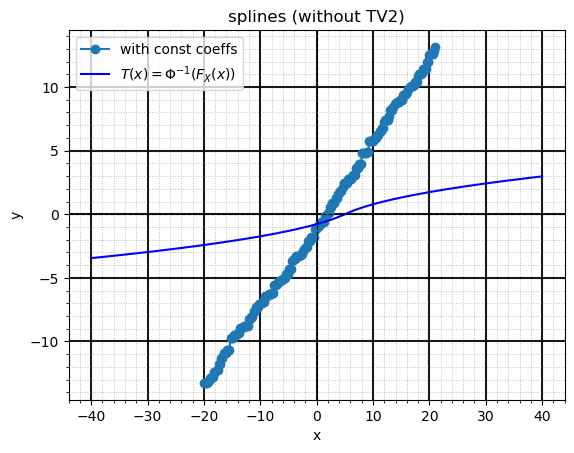

In [18]:
SIZE=201;RANGE=20; START_VAL=-20; END_VAL=21
#GRID_VALS= generate_unequally_spaced_sorted_numbers(start_val=START_VAL,end_val=END_VAL,N=SIZE)
GRID_VALS,FN_INIT = transformation_laplace_to_std_normal(mu=mean, b=scale, x_range=(START_VAL,END_VAL), num_points=SIZE)
noise = torch.randn_like(torch.tensor(FN_INIT)) * 2e-1
model2 = LinearSplineSlopeConstrained(
                mode='fc',
                num_activations=1,
                size=SIZE,# number of knots is size -2
                range_=RANGE,
                grid_values=torch.tensor(GRID_VALS),
                # grid_values=torch.tensor([-2.9132, -1.,  1.8,  2.1882,  2.9779]),
                init="manual",#"maxmin",# what if I try relu activation function?
                smin=0.001,
                smax=10,
                slope_constrained=1,
                manual_init_fn_tensor=torch.tensor(FN_INIT)+noise
) 
# print("constrained coefficients are: ",model2.slope_constrained_coefficients_vect)
# print(f"slopes: constrained coeffs: {model2.slopes_tensor(for_projected_coeffs=1)}")
# visualise the code space before the training
input_tensor = torch.tensor(train_data)
output_tensor2=model2(input_tensor)
# plot_multiple_histogram([input_tensor.numpy(), output_tensor2.detach().numpy()
#                         ],
#                         labels_list=["data_space (x)","code_space(z)"])

x2pos, y2pos = model2.nodal_val_loc_tensor.detach().numpy(), model2.slope_constrained_coefficients_vect.detach().numpy()
# print('grid vals and x2pos vals')
# print(GRID_VALS, x2pos)
# print('fn val and slope constrained fn val')
# print(FN_INIT, y2pos)
    # Add labels, title, and grid
    # plt.figure(figsize=(8,8))
plt.figure()
plot_with_annotations(x2pos[0][:], y2pos[:],
                    title="splines (without TV2)", xlabel="x", ylabel="y",
                    annotate=0, style='-o')
plt.legend()
plt.show()

In [19]:
# with torch.no_grad():
#    zz,gg=model2(torch.tensor([[-30.], [-20], [0.], [20], [30]])), model2.grad_x_temp
# zz,gg, zz**2

In [20]:
# training 100 rounds with low tv2 regularization
train_loss2, val_loss2, epoch_wise_param_list,coeffs_unconstrained_evol2, coeffs_const_evol2 = train_and_evaluate(
    model = model2,
    train_loader=train_loader,
    val_loader=val_loader, 
    num_epochs=30, 
    scheduler_type="ReduceLROnPlateau",
    lr=0.0005,#0.004
    print_after=1,   
    track_coefficients=1, #
    type_model="scls", 
    tv2_regulation= 1, 
    lambda_tv2=0.001,#0.095, 
    gamma = 0.5, # schedular, learning rate decay factor
    alpha_nll=1# We don;t need any alpha anymore! get rid of this in the code later
) # why is it no # good thing is that it is shifting but the bad thing is that its kind of collapsing to 0 . NOT ANYMORE

Training Progress:   3%|▎         | 1/30 [00:19<09:16, 19.19s/it]

Epoch 1/30,  train NLL+0.001XTV2: 16.63738984384578, data avg loss-1: 13.153412469654732 ,data avg loss-2: -3.3298419675847875 ,Training NLL Loss: 16.483254437239527, Validation NLL Loss: 11.987226331368424, LR: 0.0005


Training Progress:   7%|▋         | 2/30 [00:37<08:50, 18.95s/it]

Epoch 2/30,  train NLL+0.001XTV2: 9.588675249842494, data avg loss-1: 5.975757329313857 ,data avg loss-2: -3.5165012662966273 ,Training NLL Loss: 9.492258595610494, Validation NLL Loss: 7.81337020505907, LR: 0.0005


Training Progress:  10%|█         | 3/30 [00:56<08:29, 18.89s/it]

Epoch 3/30,  train NLL+0.001XTV2: 6.691571677220324, data avg loss-1: 3.018530478764312 ,data avg loss-2: -3.609792584677689 ,Training NLL Loss: 6.628323063442, Validation NLL Loss: 5.828561347479457, LR: 0.0005


Training Progress:  13%|█▎        | 4/30 [01:15<08:09, 18.82s/it]

Epoch 4/30,  train NLL+0.001XTV2: 5.1773230170758255, data avg loss-1: 1.4960224349173283 ,data avg loss-2: -3.640084010944555 ,Training NLL Loss: 5.136106445861882, Validation NLL Loss: 4.837445580967598, LR: 0.0005


Training Progress:  17%|█▋        | 5/30 [01:34<07:48, 18.73s/it]

Epoch 5/30,  train NLL+0.001XTV2: 4.464067702062809, data avg loss-1: 0.9728682526965166 ,data avg loss-2: -3.463915400109355 ,Training NLL Loss: 4.436783652805882, Validation NLL Loss: 4.0680595152960235, LR: 0.0005


Training Progress:  20%|██        | 6/30 [01:52<07:29, 18.71s/it]

Epoch 6/30,  train NLL+0.001XTV2: 3.75848905743314, data avg loss-1: 0.7553744521928157 ,data avg loss-2: -2.9853153911262837 ,Training NLL Loss: 3.740689843319104, Validation NLL Loss: 3.5340371963563024, LR: 0.0005


Training Progress:  23%|██▎       | 7/30 [02:11<07:08, 18.65s/it]

Epoch 7/30,  train NLL+0.001XTV2: 3.3542390586860793, data avg loss-1: 0.6213896436140925 ,data avg loss-2: -2.7222443368920692 ,Training NLL Loss: 3.3436339805061572, Validation NLL Loss: 3.266268658755881, LR: 0.0005


Training Progress:  27%|██▋       | 8/30 [02:29<06:49, 18.61s/it]

Epoch 8/30,  train NLL+0.001XTV2: 3.124422522274357, data avg loss-1: 0.5529587874488556 ,data avg loss-2: -2.565388885533313 ,Training NLL Loss: 3.1183476729821646, Validation NLL Loss: 3.0947679307229103, LR: 0.0005


Training Progress:  30%|███       | 9/30 [02:48<06:30, 18.58s/it]

Epoch 9/30,  train NLL+0.001XTV2: 3.016833980797737, data avg loss-1: 0.5115814162087854 ,data avg loss-2: -2.5011701374933697 ,Training NLL Loss: 3.0127515537021603, Validation NLL Loss: 3.0405318921962823, LR: 0.0005


Training Progress:  33%|███▎      | 10/30 [03:06<06:11, 18.58s/it]

Epoch 10/30,  train NLL+0.001XTV2: 2.9512066612605032, data avg loss-1: 0.4982959506930807 ,data avg loss-2: -2.449912722852702 ,Training NLL Loss: 2.948208673545774, Validation NLL Loss: 2.931618466350845, LR: 0.0005


Training Progress:  37%|███▋      | 11/30 [03:25<05:54, 18.67s/it]

Epoch 11/30,  train NLL+0.001XTV2: 2.889222372279686, data avg loss-1: 0.4920681937764203 ,data avg loss-2: -2.3949174790462027 ,Training NLL Loss: 2.8869856728226275, Validation NLL Loss: 2.8915565054447114, LR: 0.0005


Training Progress:  40%|████      | 12/30 [03:44<05:35, 18.65s/it]

Epoch 12/30,  train NLL+0.001XTV2: 2.8701127412219805, data avg loss-1: 0.4845092247738858 ,data avg loss-2: -2.3836368655120763 ,Training NLL Loss: 2.8681460902859595, Validation NLL Loss: 2.885423217333555, LR: 0.0005


Training Progress:  43%|████▎     | 13/30 [04:02<05:16, 18.62s/it]

Epoch 13/30,  train NLL+0.001XTV2: 2.8725415403313357, data avg loss-1: 0.46897074604948397 ,data avg loss-2: -2.4017188207156246 ,Training NLL Loss: 2.870689566765109, Validation NLL Loss: 2.8925492979592247, LR: 0.0005


Training Progress:  47%|████▋     | 14/30 [04:21<04:58, 18.63s/it]

Epoch 14/30,  train NLL+0.001XTV2: 2.8575169699123744, data avg loss-1: 0.46665423292883207 ,data avg loss-2: -2.3891226236521765 ,Training NLL Loss: 2.8557768565810147, Validation NLL Loss: 2.8978155728711776, LR: 0.0005


Training Progress:  50%|█████     | 15/30 [04:40<04:39, 18.61s/it]

Epoch 15/30,  train NLL+0.001XTV2: 2.8746776096965516, data avg loss-1: 0.46195873732118625 ,data avg loss-2: -2.4110621578177445 ,Training NLL Loss: 2.873020895138926, Validation NLL Loss: 2.8942395886715775, LR: 0.0005


Training Progress:  53%|█████▎    | 16/30 [04:58<04:20, 18.60s/it]

Epoch 16/30,  train NLL+0.001XTV2: 2.866068560423888, data avg loss-1: 0.4535618063120899 ,data avg loss-2: -2.4109367166414666 ,Training NLL Loss: 2.864498522953556, Validation NLL Loss: 2.8554114052461546, LR: 0.0005


Training Progress:  57%|█████▋    | 17/30 [05:17<04:01, 18.61s/it]

Epoch 17/30,  train NLL+0.001XTV2: 2.8415317483410867, data avg loss-1: 0.44222329966819685 ,data avg loss-2: -2.397819822646344 ,Training NLL Loss: 2.840043122314538, Validation NLL Loss: 2.8519923135312784, LR: 0.0005


Training Progress:  60%|██████    | 18/30 [05:36<03:43, 18.63s/it]

Epoch 18/30,  train NLL+0.001XTV2: 2.83437718844062, data avg loss-1: 0.4392886562422204 ,data avg loss-2: -2.3936956121136346 ,Training NLL Loss: 2.8329842683558564, Validation NLL Loss: 2.8477226293730937, LR: 0.0005


Training Progress:  63%|██████▎   | 19/30 [05:54<03:24, 18.63s/it]

Epoch 19/30,  train NLL+0.001XTV2: 2.8259326041263435, data avg loss-1: 0.43720773361101106 ,data avg loss-2: -2.387400261107157 ,Training NLL Loss: 2.824607994718166, Validation NLL Loss: 2.8446070630224733, LR: 0.0005


Training Progress:  67%|██████▋   | 20/30 [06:13<03:05, 18.57s/it]

Epoch 20/30,  train NLL+0.001XTV2: 2.828505688334101, data avg loss-1: 0.4316688981657602 ,data avg loss-2: -2.395583242218933 ,Training NLL Loss: 2.827252140384695, Validation NLL Loss: 2.84545121620128, LR: 0.0005


Training Progress:  70%|███████   | 21/30 [06:31<02:47, 18.63s/it]

Epoch 21/30,  train NLL+0.001XTV2: 2.825490977787336, data avg loss-1: 0.42557696701413245 ,data avg loss-2: -2.398665609200588 ,Training NLL Loss: 2.824242576214718, Validation NLL Loss: 2.8422640176031906, LR: 0.0005


Training Progress:  73%|███████▎  | 22/30 [06:50<02:29, 18.64s/it]

Epoch 22/30,  train NLL+0.001XTV2: 2.8152240971258062, data avg loss-1: 0.4233170843731852 ,data avg loss-2: -2.390659618348046 ,Training NLL Loss: 2.8139767027212326, Validation NLL Loss: 2.834613243623831, LR: 0.0005


Training Progress:  77%|███████▋  | 23/30 [07:09<02:10, 18.67s/it]

Epoch 23/30,  train NLL+0.001XTV2: 2.8015569485459655, data avg loss-1: 0.42457972228694857 ,data avg loss-2: -2.3759249684515624 ,Training NLL Loss: 2.800504690738506, Validation NLL Loss: 2.832069589436929, LR: 0.0005


Training Progress:  80%|████████  | 24/30 [07:27<01:52, 18.69s/it]

Epoch 24/30,  train NLL+0.001XTV2: 2.80727276958185, data avg loss-1: 0.4179158117289652 ,data avg loss-2: -2.388296382630863 ,Training NLL Loss: 2.806212194359819, Validation NLL Loss: 2.8311611933219663, LR: 0.0005


Training Progress:  83%|████████▎ | 25/30 [07:46<01:33, 18.68s/it]

Epoch 25/30,  train NLL+0.001XTV2: 2.8095446573257576, data avg loss-1: 0.41291648094788475 ,data avg loss-2: -2.395580007785591 ,Training NLL Loss: 2.8084964887334807, Validation NLL Loss: 2.8307099661203825, LR: 0.0005


Training Progress:  87%|████████▋ | 26/30 [08:06<01:15, 18.96s/it]

Epoch 26/30,  train NLL+0.001XTV2: 2.8129642481894614, data avg loss-1: 0.4077445958031962 ,data avg loss-2: -2.404139737007048 ,Training NLL Loss: 2.811884332810243, Validation NLL Loss: 2.834035614208749, LR: 0.00025


Training Progress:  90%|█████████ | 27/30 [08:25<00:56, 18.98s/it]

Epoch 27/30,  train NLL+0.001XTV2: 2.815471187602301, data avg loss-1: 0.40523837065712354 ,data avg loss-2: -2.409381676554967 ,Training NLL Loss: 2.8146200472120952, Validation NLL Loss: 2.8392181848871894, LR: 0.00025


Training Progress:  93%|█████████▎| 28/30 [08:43<00:37, 18.88s/it]

Epoch 28/30,  train NLL+0.001XTV2: 2.8165996243516607, data avg loss-1: 0.401885040691198 ,data avg loss-2: -2.4139331201124654 ,Training NLL Loss: 2.815818160803663, Validation NLL Loss: 2.835825598355282, LR: 0.00025


Training Progress:  97%|█████████▋| 29/30 [09:02<00:18, 18.82s/it]

Epoch 29/30,  train NLL+0.001XTV2: 2.8001827109459336, data avg loss-1: 0.4096946295200506 ,data avg loss-2: -2.3896478453793124 ,Training NLL Loss: 2.7993424748993605, Validation NLL Loss: 2.837789052185628, LR: 0.00025


Training Progress: 100%|██████████| 30/30 [09:21<00:00, 18.71s/it]

Epoch 30/30,  train NLL+0.001XTV2: 2.816361004601722, data avg loss-1: 0.3971576669285305 ,data avg loss-2: -2.4184679431285714 ,Training NLL Loss: 2.8156256100570993, Validation NLL Loss: 2.8381891148776015, LR: 0.00025
Training complete


In [21]:
# plot different plots to visualise the training dynamics
def analyse_training(model_in, test_data,train_loss, val_loss,model_params_list,
                    num_coeffs ,figsize=(12,12),num_samples=20000,
                    print_model_params=0, plot_freq=5
                    ):
    input_tensor = torch.tensor(test_data)
    output_tensor2 = model_in(input_tensor)
    plot_multiple_histogram([input_tensor.numpy(), output_tensor2.detach().numpy()],
                            labels_list=["original_space (x)", "code_space(z)"])

    plot_loss_curves(train_loss=train_loss, val_loss=val_loss,
                    title="linear-spline model slope constrained", log_scale=1)

    x2pos, y2pos = model_in.nodal_val_loc_tensor.detach().numpy(), model_in.slope_constrained_coefficients_vect.detach().numpy()
    # Add labels, title, and grid
    # plt.figure(figsize=(8,8))
    
    plot_with_annotations(x2pos[0][:], y2pos[:],
                        title="splines (without TV2)", xlabel="x", ylabel="y", annotate=0, style="-*")
    plt.legend()
    plt.show()
    ## 
    #print(f"slopes: constrained coeffs: {model_in.slopes_tensor(for_projected_coeffs=1)}")
    #plot_coefficients_evolution(num_coeffs,
    #                            np.array(coeffs_unconstrained_evol2), 
    #                            np.array(coeffs_const_evol2), log_scale=0)
    
    model = LinearSplineSlopeConstrained(
                        mode='fc',
                        num_activations=1,
                        size=SIZE,# number of knots is size -2
                        range_=RANGE,
                        grid_values=model_in.nodal_val_loc_tensor.detach().reshape(-1),
                        init="maxmin",#"maxmin",# what if I try relu activation function?
                        smin=0.01,
                        smax=2,
                        slope_constrained=1
) 
    
    plot_multiple_z_with_normal_1d(models_params=model_params_list,test_data=test_data,
                                model=model,figsize=figsize, num_samples=num_samples,
                                print_model_params=print_model_params, plot_frequency=plot_freq)


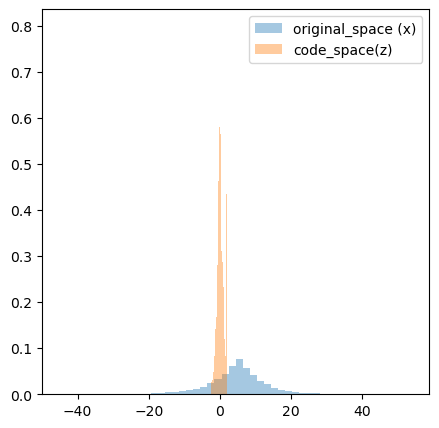

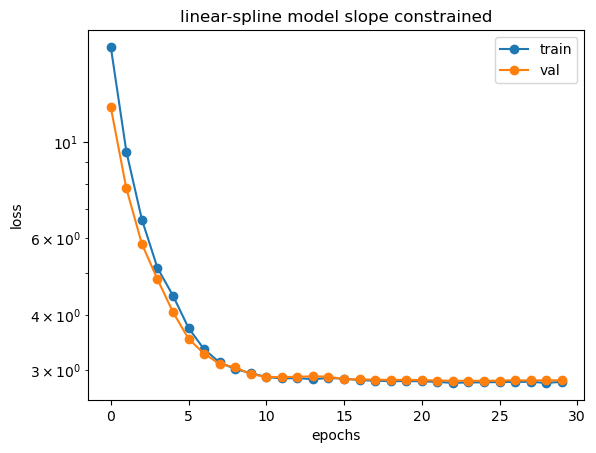

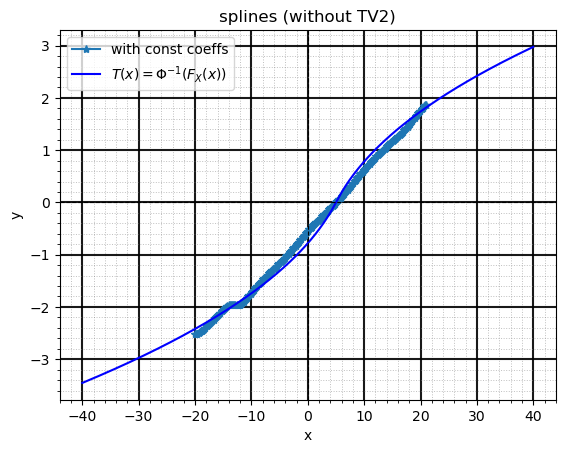

/home/neel/Desktop/Lipschitz_DSNN/activations/linearspline_slope_constraint.py:208: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.nodal_val_loc_tensor = torch.tensor(grid_values).expand((num_activations, size))


initial nodal_val_locs: tensor([[-20.0000, -19.7950, -19.5900, -19.3850, -19.1800, -18.9750, -18.7700,
         -18.5650, -18.3600, -18.1550, -17.9500, -17.7450, -17.5400, -17.3350,
         -17.1300, -16.9250, -16.7200, -16.5150, -16.3100, -16.1050, -15.9000,
         -15.6950, -15.4900, -15.2850, -15.0800, -14.8750, -14.6700, -14.4650,
         -14.2600, -14.0550, -13.8500, -13.6450, -13.4400, -13.2350, -13.0300,
         -12.8250, -12.6200, -12.4150, -12.2100, -12.0050, -11.8000, -11.5950,
         -11.3900, -11.1850, -10.9800, -10.7750, -10.5700, -10.3650, -10.1600,
          -9.9550,  -9.7500,  -9.5450,  -9.3400,  -9.1350,  -8.9300,  -8.7250,
          -8.5200,  -8.3150,  -8.1100,  -7.9050,  -7.7000,  -7.4950,  -7.2900,
          -7.0850,  -6.8800,  -6.6750,  -6.4700,  -6.2650,  -6.0600,  -5.8550,
          -5.6500,  -5.4450,  -5.2400,  -5.0350,  -4.8300,  -4.6250,  -4.4200,
          -4.2150,  -4.0100,  -3.8050,  -3.6000,  -3.3950,  -3.1900,  -2.9850,
          -2.7800,  -2.5750,

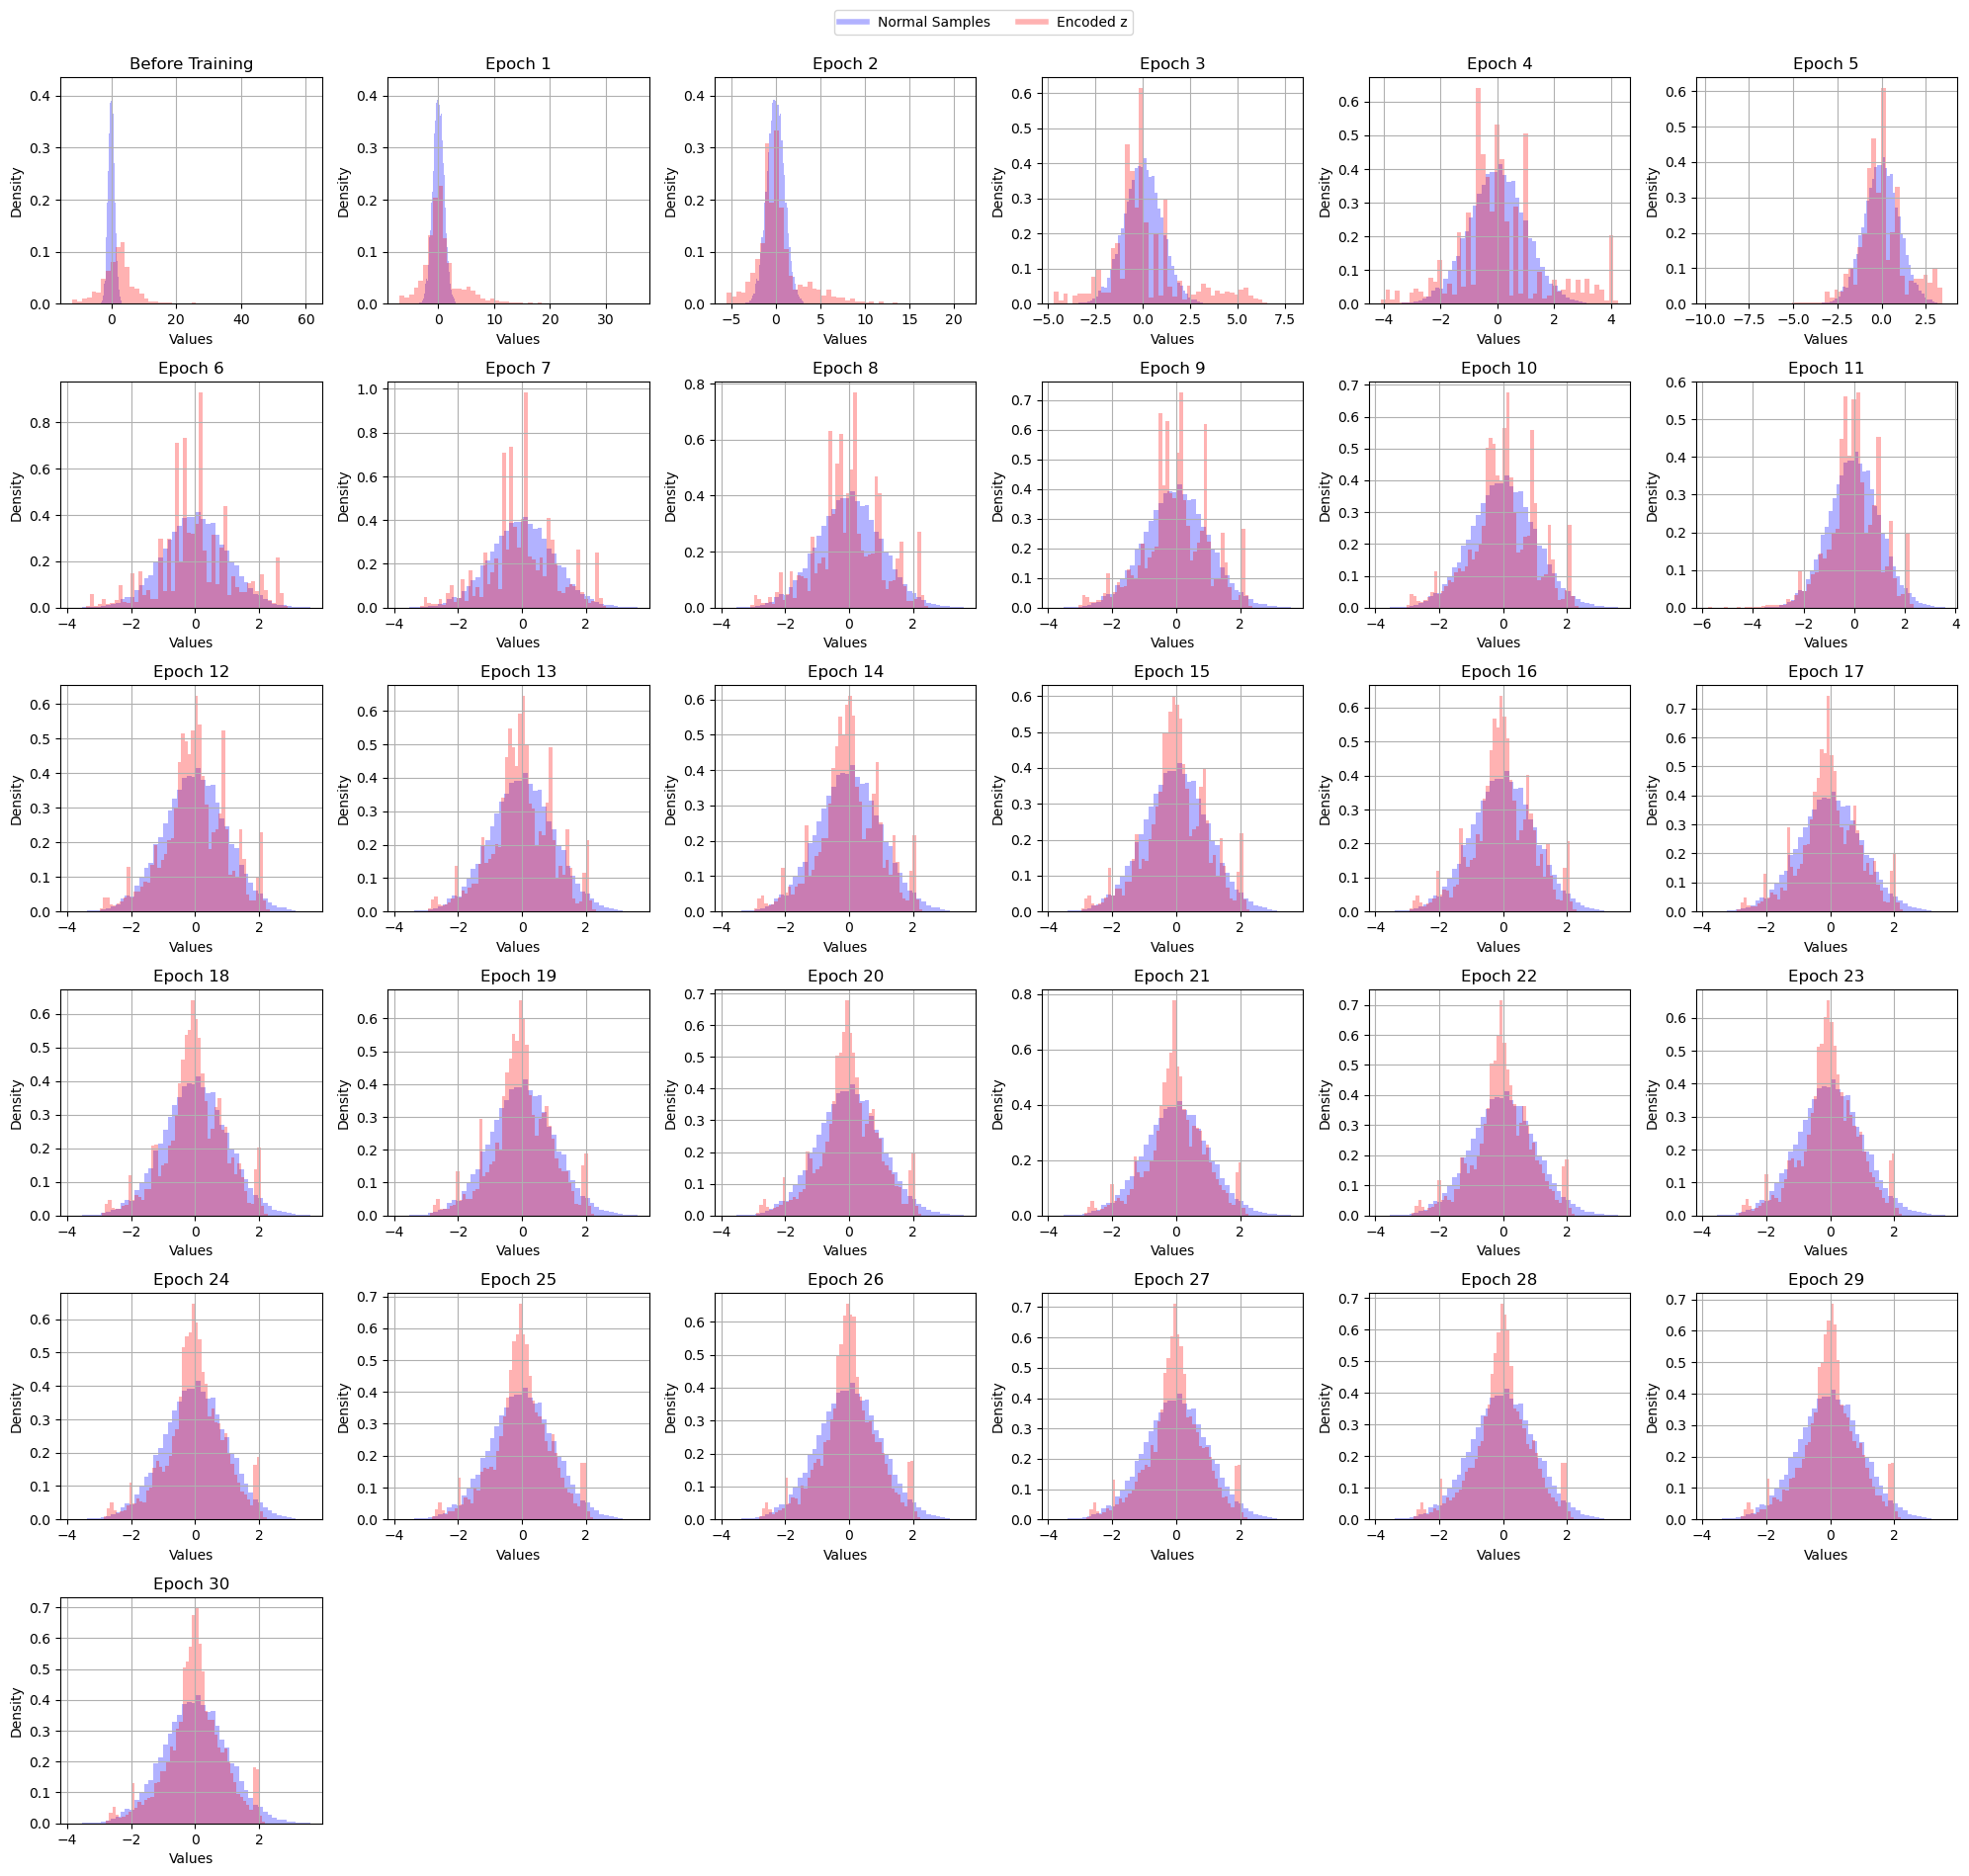

In [22]:
analyse_training(model_in=model2,
train_loss=train_loss2, val_loss=val_loss2, 
                test_data=test_data, figsize=(20,20),
                model_params_list=epoch_wise_param_list,
                num_coeffs=10,print_model_params=0, plot_freq=1) # 40 more (30 below+40 x3 below + 40  more= 70+40+40 + 40=110+40 +40=150+40=190)

In [25]:
from scipy.interpolate import CubicSpline

In [26]:
def create_spline_interpolator(x, y, kind='cubic'):
    """
    Creates an interpolation function based on given x and y values.
    
    Parameters:
    - x: array-like, input x values.
    - y: array-like, corresponding y values.
    - kind: str, type of interpolation ('linear', 'quadratic', 'cubic').
    
    Returns:
    - interp_function: function that takes new x values and returns interpolated y values.
    """
    if kind == 'cubic':
        interp_function = CubicSpline(x, y)
    else:
        from scipy.interpolate import interp1d
        interp_function = interp1d(x, y, kind=kind, fill_value="extrapolate")
    
    return interp_function  # This function can now be used for new x values

In [27]:
xdata, ydata = model2.nodal_val_loc_tensor.detach().numpy(), model2.slope_constrained_coefficients_vect.detach().numpy()

In [ ]:
from scipy.interpolate import interp1d, CubicSpline

def create_spline_interpolators(x, y):
    """
    Creates linear, quadratic, and cubic spline interpolators.

    Parameters:
    - x: array-like, input x values.
    - y: array-like, corresponding y values.

    Returns:
    - Dictionary containing interpolation functions for each kind.
    """
    inter_fns = {
        'linear': interp1d(x, y, kind='linear', fill_value="extrapolate"),
        'quadratic': interp1d(x, y, kind='quadratic', fill_value="extrapolate"),
        'cubic': CubicSpline(x, y)  # Equivalent to interp1d with kind='cubic'
    }
    return inter_fns

# Get interpolators
interpolators = create_spline_interpolators(xdata[0], ydata)

# Generate dense x values for smooth plotting
x_dense = np.linspace(xdata.min() - 0.5, xdata.max() + 0.5, 200)

# Compute interpolated values for each method
y_linear = interpolators['linear'](x_dense)
y_quadratic = interpolators['quadratic'](x_dense)
y_cubic = interpolators['cubic'](x_dense)

# Create subplots
fig, axes = plt.subplots(3, 1, figsize=(7, 7), sharex=True)

# Linear Spline
axes[0].plot(xdata[0], ydata, 'o', label='Data Points', markersize=8)
axes[0].plot(x_dense, y_linear, '-', label='Linear Spline', linewidth=1.5)
axes[0].set_ylabel("Interpolated y")
axes[0].set_title("Linear Spline")
axes[0].legend()
axes[0].grid(True)

# Quadratic Spline
axes[1].plot(xdata[0], ydata, 'o', label='Data Points', markersize=8)
axes[1].plot(x_dense, y_quadratic, '-', label='Quadratic Spline', linewidth=1.5)
axes[1].set_ylabel("Interpolated y")
axes[1].set_title("Quadratic Spline")
axes[1].legend()
axes[1].grid(True)

# Cubic Spline
axes[2].plot(xdata[0], ydata, 'o', label='Data Points', markersize=8)
axes[2].plot(x_dense, y_cubic, '-', label='Cubic Spline', linewidth=2)
axes[2].set_xlabel("x")
axes[2].set_ylabel("Interpolated y")
axes[2].set_title("Cubic Spline")
axes[2].legend()
axes[2].grid(True)

# Adjust layout
plt.tight_layout()
plt.show()


In [29]:
interpolators

{'linear': <scipy.interpolate._interpolate.interp1d at 0x7e44b97f8ea0>,
 'quadratic': <scipy.interpolate._interpolate.interp1d at 0x7e44b979e2c0>,
 'cubic': <scipy.interpolate._cubic.CubicSpline at 0x7e44fca2c4f0>}

In [30]:
y_lin, y_quad, y_cubic = interpolators['linear'](test_data), interpolators['quadratic'](test_data), interpolators['cubic'](test_data)
with torch.no_grad():
    model_op = model2(torch.tensor(test_data, dtype=torch.float))

In [ ]:
plot_multiple_histogram([np.random.normal(0, 1, num_samples), 
                        y_lin,
                        model_op.squeeze().numpy()
                        ],
                        labels_list=["normal", 
                                     "linear",
                                     "model output"
                                     ])

In [32]:
# 2ND TIME training 100 more rounds
train_loss2, val_loss2, epoch_wise_param_list,coeffs_unconstrained_evol2, coeffs_const_evol2 = train_and_evaluate(
    model = model2,
    train_loader=train_loader,
    val_loader=val_loader, 
    num_epochs=100, 
    scheduler_type="ReduceLROnPlateau",
    lr=0.000095,#0.004
    print_after=1,   
    track_coefficients=1, #
    type_model="scls", 
    tv2_regulation= 1, 
    lambda_tv2=0.001,#0.095, 
    gamma = 0.5, # schedular, learning rate decay factor
    alpha_nll=1
) 

Training Progress:   1%|          | 1/100 [00:09<15:26,  9.36s/it]

Epoch 1/100,  train NLL+0.001XTV2: 2.9736626542635416, data avg loss-1: 0.5096400771964186 ,data avg loss-2: -2.4601609073220936 ,Training NLL Loss: 2.9698009845185114, Validation NLL Loss: 3.0432205481941383, LR: 9.5e-05


Training Progress:   2%|▏         | 2/100 [00:18<15:10,  9.29s/it]

Epoch 2/100,  train NLL+0.001XTV2: 2.9539524456345747, data avg loss-1: 0.5075290224433034 ,data avg loss-2: -2.442748990093629 ,Training NLL Loss: 2.950278012536932, Validation NLL Loss: 3.0213430489024375, LR: 9.5e-05


Training Progress:   3%|▎         | 3/100 [00:27<15:00,  9.28s/it]

Epoch 3/100,  train NLL+0.001XTV2: 2.9272621559654883, data avg loss-1: 0.5071589425355442 ,data avg loss-2: -2.4165664304740626 ,Training NLL Loss: 2.9237253730096042, Validation NLL Loss: 3.056937937870714, LR: 9.5e-05


Training Progress:   4%|▍         | 4/100 [00:37<14:47,  9.24s/it]

Epoch 4/100,  train NLL+0.001XTV2: 2.9657080091046333, data avg loss-1: 0.5011708256601264 ,data avg loss-2: -2.461169767604967 ,Training NLL Loss: 2.9623405932650932, Validation NLL Loss: 3.0591352746818523, LR: 9.5e-05


Training Progress:   5%|▌         | 5/100 [00:46<14:41,  9.28s/it]

Epoch 5/100,  train NLL+0.001XTV2: 2.966886965723815, data avg loss-1: 0.49719373962075525 ,data avg loss-2: -2.466481076685767 ,Training NLL Loss: 2.963674816306521, Validation NLL Loss: 3.0584766940496655, LR: 9.5e-05


Training Progress:   6%|▌         | 6/100 [00:55<14:30,  9.26s/it]

Epoch 6/100,  train NLL+0.001XTV2: 2.9614560586014256, data avg loss-1: 0.49544997363431964 ,data avg loss-2: -2.462917413303596 ,Training NLL Loss: 2.9583673869379155, Validation NLL Loss: 3.041473148140265, LR: 4.75e-05


Training Progress:   7%|▋         | 7/100 [01:04<14:21,  9.26s/it]

Epoch 7/100,  train NLL+0.001XTV2: 2.948936415401413, data avg loss-1: 0.4934595485974119 ,data avg loss-2: -2.4524959039034235 ,Training NLL Loss: 2.945955452500835, Validation NLL Loss: 3.03338373240398, LR: 4.75e-05


Training Progress:   8%|▊         | 8/100 [01:14<14:11,  9.26s/it]

Epoch 8/100,  train NLL+0.001XTV2: 2.9398879803401723, data avg loss-1: 0.492612253954061 ,data avg loss-2: -2.4443556366934347 ,Training NLL Loss: 2.9369678906474967, Validation NLL Loss: 3.028150637201125, LR: 4.75e-05


Training Progress:   9%|▉         | 9/100 [01:23<14:03,  9.27s/it]

Epoch 9/100,  train NLL+0.001XTV2: 2.927704800169605, data avg loss-1: 0.49186909696300873 ,data avg loss-2: -2.4329737589212415 ,Training NLL Loss: 2.9248428558842505, Validation NLL Loss: 2.9931591541842733, LR: 2.375e-05


Training Progress:  10%|█         | 10/100 [01:32<13:53,  9.27s/it]

Epoch 10/100,  train NLL+0.001XTV2: 2.9178831612571763, data avg loss-1: 0.4920767968908309 ,data avg loss-2: -2.4229960285484657 ,Training NLL Loss: 2.9150728254392964, Validation NLL Loss: 2.9909953553165907, LR: 2.375e-05


Training Progress:  11%|█         | 11/100 [01:42<13:48,  9.31s/it]

Epoch 11/100,  train NLL+0.001XTV2: 2.9145892953288737, data avg loss-1: 0.4919924834645857 ,data avg loss-2: -2.4198219490688837 ,Training NLL Loss: 2.9118144325334705, Validation NLL Loss: 2.9932718078766474, LR: 2.375e-05


Training Progress:  12%|█▏        | 12/100 [01:51<13:44,  9.37s/it]

Epoch 12/100,  train NLL+0.001XTV2: 2.9158688513678244, data avg loss-1: 0.49160639360621605 ,data avg loss-2: -2.4215162067237315 ,Training NLL Loss: 2.9131226003299475, Validation NLL Loss: 2.9907691564205203, LR: 2.375e-05


Training Progress:  13%|█▎        | 13/100 [02:00<13:31,  9.32s/it]

Epoch 13/100,  train NLL+0.001XTV2: 2.9108978956181524, data avg loss-1: 0.4915631499334339 ,data avg loss-2: -2.4166144464672663 ,Training NLL Loss: 2.908177596400702, Validation NLL Loss: 2.900923801309806, LR: 2.375e-05


Training Progress:  14%|█▍        | 14/100 [02:09<13:17,  9.28s/it]

Epoch 14/100,  train NLL+0.001XTV2: 2.8754269744836662, data avg loss-1: 0.4923812909856536 ,data avg loss-2: -2.38035728325753 ,Training NLL Loss: 2.872738574243184, Validation NLL Loss: 2.994964452004564, LR: 2.375e-05


Training Progress:  15%|█▌        | 15/100 [02:18<12:59,  9.18s/it]

Epoch 15/100,  train NLL+0.001XTV2: 2.9131924090065775, data avg loss-1: 0.49090793615292566 ,data avg loss-2: -2.4196187443507435 ,Training NLL Loss: 2.9105266805036716, Validation NLL Loss: 2.981877356726976, LR: 2.375e-05


Training Progress:  16%|█▌        | 16/100 [02:27<12:45,  9.11s/it]

Epoch 16/100,  train NLL+0.001XTV2: 2.908897562370985, data avg loss-1: 0.4906134897831624 ,data avg loss-2: -2.415646398420603 ,Training NLL Loss: 2.906259888203765, Validation NLL Loss: 2.9825301952333656, LR: 2.375e-05


Training Progress:  17%|█▋        | 17/100 [02:37<12:39,  9.15s/it]

Epoch 17/100,  train NLL+0.001XTV2: 2.9084746779412884, data avg loss-1: 0.49031960708742656 ,data avg loss-2: -2.4155462764488673 ,Training NLL Loss: 2.9058658835362965, Validation NLL Loss: 2.9853111731655715, LR: 1.1875e-05


Training Progress:  18%|█▊        | 18/100 [02:46<12:32,  9.18s/it]

Epoch 18/100,  train NLL+0.001XTV2: 2.9070433375610567, data avg loss-1: 0.4900961149744369 ,data avg loss-2: -2.4143657291365566 ,Training NLL Loss: 2.904461844110994, Validation NLL Loss: 2.9822490736448004, LR: 1.1875e-05


Training Progress:  19%|█▉        | 19/100 [02:55<12:22,  9.17s/it]

Epoch 19/100,  train NLL+0.001XTV2: 2.9065338041834794, data avg loss-1: 0.48999670373863735 ,data avg loss-2: -2.4139706272315524 ,Training NLL Loss: 2.9039673309701888, Validation NLL Loss: 2.979797392963058, LR: 1.1875e-05


Training Progress:  20%|██        | 20/100 [03:04<12:19,  9.24s/it]

Epoch 20/100,  train NLL+0.001XTV2: 2.9049403760924775, data avg loss-1: 0.48988223949815035 ,data avg loss-2: -2.412507916789351 ,Training NLL Loss: 2.9023901562874976, Validation NLL Loss: 2.981545785466065, LR: 5.9375e-06


Training Progress:  21%|██        | 21/100 [03:13<12:06,  9.19s/it]

Epoch 21/100,  train NLL+0.001XTV2: 2.9079057069768797, data avg loss-1: 0.48954843533499776 ,data avg loss-2: -2.4158211477160614 ,Training NLL Loss: 2.9053695830510597, Validation NLL Loss: 2.9861118376617592, LR: 5.9375e-06


Training Progress:  22%|██▏       | 22/100 [03:22<11:51,  9.12s/it]

Epoch 22/100,  train NLL+0.001XTV2: 2.9075279182310014, data avg loss-1: 0.4894355843675127 ,data avg loss-2: -2.41556518882593 ,Training NLL Loss: 2.9050007731934406, Validation NLL Loss: 2.9846405776284346, LR: 5.9375e-06


Training Progress:  23%|██▎       | 23/100 [03:31<11:38,  9.07s/it]

Epoch 23/100,  train NLL+0.001XTV2: 2.907406081036201, data avg loss-1: 0.48929388463304635 ,data avg loss-2: -2.4155937661088194 ,Training NLL Loss: 2.904887650741865, Validation NLL Loss: 2.9822285187207105, LR: 2.96875e-06


Training Progress:  24%|██▍       | 24/100 [03:40<11:26,  9.04s/it]

Epoch 24/100,  train NLL+0.001XTV2: 2.9050795944077463, data avg loss-1: 0.48933401169403884 ,data avg loss-2: -2.4132335112098477 ,Training NLL Loss: 2.9025675229038876, Validation NLL Loss: 2.9810060669753464, LR: 2.96875e-06


Training Progress:  25%|██▌       | 25/100 [03:49<11:17,  9.03s/it]

Epoch 25/100,  train NLL+0.001XTV2: 2.9045117626210026, data avg loss-1: 0.48930922556099227 ,data avg loss-2: -2.4126939819022373 ,Training NLL Loss: 2.902003207463227, Validation NLL Loss: 2.9814923720018602, LR: 2.96875e-06


Training Progress:  26%|██▌       | 26/100 [03:58<11:06,  9.01s/it]

Epoch 26/100,  train NLL+0.001XTV2: 2.903863058137058, data avg loss-1: 0.4893044687882672 ,data avg loss-2: -2.4120535621872827 ,Training NLL Loss: 2.9013580309755462, Validation NLL Loss: 2.9793786987579383, LR: 1.484375e-06


Training Progress:  27%|██▋       | 27/100 [04:07<10:57,  9.01s/it]

Epoch 27/100,  train NLL+0.001XTV2: 2.903371919653801, data avg loss-1: 0.4892957861825225 ,data avg loss-2: -2.411574750486523 ,Training NLL Loss: 2.9008705366690477, Validation NLL Loss: 2.979512705399611, LR: 1.484375e-06


Training Progress:  28%|██▊       | 28/100 [04:17<10:52,  9.06s/it]

Epoch 28/100,  train NLL+0.001XTV2: 2.903301895107741, data avg loss-1: 0.4892913521165612 ,data avg loss-2: -2.4115110189761753 ,Training NLL Loss: 2.9008023710927393, Validation NLL Loss: 2.979850164207892, LR: 1.484375e-06


Training Progress:  29%|██▉       | 29/100 [04:26<10:43,  9.06s/it]

Epoch 29/100,  train NLL+0.001XTV2: 2.903568799514109, data avg loss-1: 0.48927139287216953 ,data avg loss-2: -2.411799702857661 ,Training NLL Loss: 2.901071095729831, Validation NLL Loss: 2.980284382916869, LR: 7.421875e-07


Training Progress:  30%|███       | 30/100 [04:35<10:37,  9.11s/it]

Epoch 30/100,  train NLL+0.001XTV2: 2.9028937660063017, data avg loss-1: 0.4892582495415419 ,data avg loss-2: -2.4111396323178194 ,Training NLL Loss: 2.9003978818593614, Validation NLL Loss: 2.9809137300238646, LR: 7.421875e-07


Training Progress:  31%|███       | 31/100 [04:44<10:32,  9.16s/it]

Epoch 31/100,  train NLL+0.001XTV2: 2.904261088483774, data avg loss-1: 0.48922903392233713 ,data avg loss-2: -2.4125372417534345 ,Training NLL Loss: 2.9017662756757745, Validation NLL Loss: 2.9807162283391024, LR: 7.421875e-07


Training Progress:  32%|███▏      | 32/100 [04:54<10:30,  9.28s/it]

Epoch 32/100,  train NLL+0.001XTV2: 2.904726376961334, data avg loss-1: 0.4892128936865156 ,data avg loss-2: -2.4130195839605544 ,Training NLL Loss: 2.9022324776470683, Validation NLL Loss: 2.981629241057272, LR: 3.7109375e-07


Training Progress:  33%|███▎      | 33/100 [05:03<10:26,  9.36s/it]

Epoch 33/100,  train NLL+0.001XTV2: 2.904937328100731, data avg loss-1: 0.48920142832193636 ,data avg loss-2: -2.4132429041494423 ,Training NLL Loss: 2.902444332471378, Validation NLL Loss: 2.9817865840744284, LR: 3.7109375e-07


Training Progress:  34%|███▍      | 34/100 [05:13<10:25,  9.48s/it]

Epoch 34/100,  train NLL+0.001XTV2: 2.9049523295961377, data avg loss-1: 0.4891961195988845 ,data avg loss-2: -2.4132637741260288 ,Training NLL Loss: 2.9024598937249135, Validation NLL Loss: 2.9815614948056854, LR: 3.7109375e-07


Training Progress:  35%|███▌      | 35/100 [05:23<10:22,  9.58s/it]

Epoch 35/100,  train NLL+0.001XTV2: 2.9050473741812284, data avg loss-1: 0.4891901935211715 ,data avg loss-2: -2.41336517051833 ,Training NLL Loss: 2.9025553640395056, Validation NLL Loss: 2.981775981451641, LR: 1.85546875e-07


Training Progress:  36%|███▌      | 36/100 [05:33<10:17,  9.64s/it]

Epoch 36/100,  train NLL+0.001XTV2: 2.904989628698787, data avg loss-1: 0.4891883588608608 ,data avg loss-2: -2.413309648634471 ,Training NLL Loss: 2.9024980074953333, Validation NLL Loss: 2.98198152697598, LR: 1.85546875e-07


Training Progress:  37%|███▋      | 37/100 [05:42<10:10,  9.69s/it]

Epoch 37/100,  train NLL+0.001XTV2: 2.905104378636509, data avg loss-1: 0.4891853755089995 ,data avg loss-2: -2.4134276420012073 ,Training NLL Loss: 2.9026130175102054, Validation NLL Loss: 2.9820573145117044, LR: 1.85546875e-07


Training Progress:  38%|███▊      | 38/100 [05:52<10:01,  9.70s/it]

Epoch 38/100,  train NLL+0.001XTV2: 2.905055293144293, data avg loss-1: 0.4891859947362356 ,data avg loss-2: -2.413378190275531 ,Training NLL Loss: 2.9025641850117663, Validation NLL Loss: 2.981904729920771, LR: 9.27734375e-08


Training Progress:  39%|███▉      | 39/100 [06:01<09:46,  9.61s/it]

Epoch 39/100,  train NLL+0.001XTV2: 2.905055575355676, data avg loss-1: 0.4891849126307702 ,data avg loss-2: -2.413379779251996 ,Training NLL Loss: 2.9025646918827683, Validation NLL Loss: 2.9819711565508857, LR: 9.27734375e-08


Training Progress:  40%|████      | 40/100 [06:11<09:31,  9.52s/it]

Epoch 40/100,  train NLL+0.001XTV2: 2.905071366794376, data avg loss-1: 0.48918427920691315 ,data avg loss-2: -2.4133963450895184 ,Training NLL Loss: 2.902580624296432, Validation NLL Loss: 2.981979594441802, LR: 9.27734375e-08


Training Progress:  41%|████      | 41/100 [06:20<09:18,  9.46s/it]

Epoch 41/100,  train NLL+0.001XTV2: 2.905123480777725, data avg loss-1: 0.4891817297766717 ,data avg loss-2: -2.4134511536058287 ,Training NLL Loss: 2.9026328833824984, Validation NLL Loss: 2.9820198468015704, LR: 4.638671875e-08


Training Progress:  42%|████▏     | 42/100 [06:29<09:04,  9.39s/it]

Epoch 42/100,  train NLL+0.001XTV2: 2.9051106198264356, data avg loss-1: 0.4891814463670128 ,data avg loss-2: -2.413438687671236 ,Training NLL Loss: 2.9026201340382456, Validation NLL Loss: 2.9819899563208754, LR: 4.638671875e-08


Training Progress:  43%|████▎     | 43/100 [06:38<08:51,  9.32s/it]

Epoch 43/100,  train NLL+0.001XTV2: 2.9051258531462825, data avg loss-1: 0.4891806448209722 ,data avg loss-2: -2.413454793220512 ,Training NLL Loss: 2.902635438041485, Validation NLL Loss: 2.9820656180117897, LR: 4.638671875e-08


Training Progress:  44%|████▍     | 44/100 [06:48<08:43,  9.35s/it]

Epoch 44/100,  train NLL+0.001XTV2: 2.905176275672528, data avg loss-1: 0.4891791894962352 ,data avg loss-2: -2.4135067308324683 ,Training NLL Loss: 2.902685920328704, Validation NLL Loss: 2.9821346180810475, LR: 2.3193359375e-08


Training Progress:  45%|████▌     | 45/100 [06:57<08:32,  9.33s/it]

Epoch 45/100,  train NLL+0.001XTV2: 2.9051583569176636, data avg loss-1: 0.48917898602086884 ,data avg loss-2: -2.413489071909293 ,Training NLL Loss: 2.902668057930165, Validation NLL Loss: 2.9818286821768036, LR: 2.3193359375e-08


Training Progress:  46%|████▌     | 46/100 [07:06<08:19,  9.25s/it]

Epoch 46/100,  train NLL+0.001XTV2: 2.9048417553399757, data avg loss-1: 0.48918333896844507 ,data avg loss-2: -2.4131681938303156 ,Training NLL Loss: 2.9023515327987597, Validation NLL Loss: 2.9816432010666043, LR: 2.3193359375e-08


Training Progress:  47%|████▋     | 47/100 [07:15<08:09,  9.24s/it]

Epoch 47/100,  train NLL+0.001XTV2: 2.9048982996717525, data avg loss-1: 0.48918245163755086 ,data avg loss-2: -2.413225648764076 ,Training NLL Loss: 2.9024081004016264, Validation NLL Loss: 2.9817796114265778, LR: 1.15966796875e-08


Training Progress:  48%|████▊     | 48/100 [07:25<07:59,  9.22s/it]

Epoch 48/100,  train NLL+0.001XTV2: 2.904943211304803, data avg loss-1: 0.48918138225539226 ,data avg loss-2: -2.413271651209679 ,Training NLL Loss: 2.902453033465074, Validation NLL Loss: 2.9818561597162945, LR: 1.15966796875e-08


Training Progress:  49%|████▉     | 49/100 [07:34<07:49,  9.21s/it]

Epoch 49/100,  train NLL+0.001XTV2: 2.90500712646531, data avg loss-1: 0.48918032170813536 ,data avg loss-2: -2.4133366342269973 ,Training NLL Loss: 2.9025169559351336, Validation NLL Loss: 2.9819108521284687, LR: 1.15966796875e-08


Training Progress:  50%|█████     | 50/100 [07:43<07:44,  9.29s/it]

Epoch 50/100,  train NLL+0.001XTV2: 2.9050457383252537, data avg loss-1: 0.48917954877577585 ,data avg loss-2: -2.4133760311564263 ,Training NLL Loss: 2.902555579932206, Validation NLL Loss: 2.9819767660861323, LR: 1.15966796875e-08


Training Progress:  51%|█████     | 51/100 [07:53<07:36,  9.31s/it]

Epoch 51/100,  train NLL+0.001XTV2: 2.905099645152206, data avg loss-1: 0.4891786371570896 ,data avg loss-2: -2.413430857517643 ,Training NLL Loss: 2.902609494674735, Validation NLL Loss: 2.9820472027331504, LR: 1.15966796875e-08


Training Progress:  52%|█████▏    | 52/100 [08:02<07:27,  9.33s/it]

Epoch 52/100,  train NLL+0.001XTV2: 2.905143343503419, data avg loss-1: 0.4891779382307591 ,data avg loss-2: -2.413475263548954 ,Training NLL Loss: 2.902653201779715, Validation NLL Loss: 2.982086980086865, LR: 1.15966796875e-08


Training Progress:  53%|█████▎    | 53/100 [08:12<07:20,  9.37s/it]

Epoch 53/100,  train NLL+0.001XTV2: 2.905142727251066, data avg loss-1: 0.48917767544195123 ,data avg loss-2: -2.4134749271871545 ,Training NLL Loss: 2.902652602629105, Validation NLL Loss: 2.9820636430205725, LR: 1.15966796875e-08


Training Progress:  54%|█████▍    | 54/100 [08:21<07:09,  9.33s/it]

Epoch 54/100,  train NLL+0.001XTV2: 2.9051503951673903, data avg loss-1: 0.489177440273887 ,data avg loss-2: -2.413482845056288 ,Training NLL Loss: 2.9026602853301755, Validation NLL Loss: 2.982113399939567, LR: 1.15966796875e-08


Training Progress:  55%|█████▌    | 55/100 [08:30<06:58,  9.30s/it]

Epoch 55/100,  train NLL+0.001XTV2: 2.905185336371925, data avg loss-1: 0.4891767655139557 ,data avg loss-2: -2.4135184707723654 ,Training NLL Loss: 2.902695236286323, Validation NLL Loss: 2.982161551827226, LR: 1.15966796875e-08


Training Progress:  56%|█████▌    | 56/100 [08:39<06:49,  9.30s/it]

Epoch 56/100,  train NLL+0.001XTV2: 2.9052104272916046, data avg loss-1: 0.48917625964514483 ,data avg loss-2: -2.4135440788504834 ,Training NLL Loss: 2.9027203384956275, Validation NLL Loss: 2.9821554147033487, LR: 1.15966796875e-08


Training Progress:  57%|█████▋    | 57/100 [08:48<06:37,  9.24s/it]

Epoch 57/100,  train NLL+0.001XTV2: 2.9052058291816425, data avg loss-1: 0.48917632644113335 ,data avg loss-2: -2.4135394333665996 ,Training NLL Loss: 2.902715759807733, Validation NLL Loss: 2.9821620937085385, LR: 1.15966796875e-08


Training Progress:  58%|█████▊    | 58/100 [08:58<06:29,  9.28s/it]

Epoch 58/100,  train NLL+0.001XTV2: 2.9052384849334123, data avg loss-1: 0.4891756909865127 ,data avg loss-2: -2.4135727354368677 ,Training NLL Loss: 2.9027484264233805, Validation NLL Loss: 2.9822117548744447, LR: 1.15966796875e-08


Training Progress:  59%|█████▉    | 59/100 [09:07<06:19,  9.25s/it]

Epoch 59/100,  train NLL+0.001XTV2: 2.90526646720058, data avg loss-1: 0.4891752604142485 ,data avg loss-2: -2.4136011564346838 ,Training NLL Loss: 2.902776416848934, Validation NLL Loss: 2.9822362864593597, LR: 1.15966796875e-08


Training Progress:  60%|██████    | 60/100 [09:16<06:12,  9.32s/it]

Epoch 60/100,  train NLL+0.001XTV2: 2.905267561977129, data avg loss-1: 0.48917497903797247 ,data avg loss-2: -2.413602546895952 ,Training NLL Loss: 2.902777525933924, Validation NLL Loss: 2.982236230113625, LR: 1.15966796875e-08


Training Progress:  61%|██████    | 61/100 [09:26<06:05,  9.36s/it]

Epoch 61/100,  train NLL+0.001XTV2: 2.9052744710522433, data avg loss-1: 0.48917473189513455 ,data avg loss-2: -2.4136097194413217 ,Training NLL Loss: 2.902784451336453, Validation NLL Loss: 2.982216569925978, LR: 1.15966796875e-08


Training Progress:  62%|██████▏   | 62/100 [09:35<05:54,  9.32s/it]

Epoch 62/100,  train NLL+0.001XTV2: 2.9052602494608895, data avg loss-1: 0.48917481960164766 ,data avg loss-2: -2.4135954263411468 ,Training NLL Loss: 2.9027702459427944, Validation NLL Loss: 2.9822260232896776, LR: 1.15966796875e-08


Training Progress:  63%|██████▎   | 63/100 [09:44<05:42,  9.25s/it]

Epoch 63/100,  train NLL+0.001XTV2: 2.9052710792482115, data avg loss-1: 0.4891745968188075 ,data avg loss-2: -2.413606490729126 ,Training NLL Loss: 2.9027810875479347, Validation NLL Loss: 2.982262475027142, LR: 1.15966796875e-08


Training Progress:  64%|██████▍   | 64/100 [09:53<05:30,  9.17s/it]

Epoch 64/100,  train NLL+0.001XTV2: 2.9052864736100146, data avg loss-1: 0.4891743421149594 ,data avg loss-2: -2.41362214961225 ,Training NLL Loss: 2.902796491727208, Validation NLL Loss: 2.9822517127593025, LR: 1.15966796875e-08


Training Progress:  65%|██████▌   | 65/100 [10:02<05:20,  9.14s/it]

Epoch 65/100,  train NLL+0.001XTV2: 2.9052761810292935, data avg loss-1: 0.4891743655985572 ,data avg loss-2: -2.413611849868028 ,Training NLL Loss: 2.902786215466585, Validation NLL Loss: 2.9822439898657986, LR: 1.15966796875e-08


Training Progress:  66%|██████▌   | 66/100 [10:11<05:10,  9.14s/it]

Epoch 66/100,  train NLL+0.001XTV2: 2.9052783674060185, data avg loss-1: 0.4891741933599036 ,data avg loss-2: -2.413614224011879 ,Training NLL Loss: 2.902788417371783, Validation NLL Loss: 2.9822587066771424, LR: 1.15966796875e-08


Training Progress:  67%|██████▋   | 67/100 [10:21<05:05,  9.24s/it]

Epoch 67/100,  train NLL+0.001XTV2: 2.9052003453085398, data avg loss-1: 0.48917501728449664 ,data avg loss-2: -2.4135353956663104 ,Training NLL Loss: 2.9027104129508072, Validation NLL Loss: 2.9821144208069823, LR: 1.15966796875e-08


Training Progress:  68%|██████▊   | 68/100 [10:30<04:56,  9.27s/it]

Epoch 68/100,  train NLL+0.001XTV2: 2.905289905696265, data avg loss-1: 0.4891737032132387 ,data avg loss-2: -2.413626281020437 ,Training NLL Loss: 2.902799984233676, Validation NLL Loss: 2.9822675518490653, LR: 1.15966796875e-08


Training Progress:  69%|██████▉   | 69/100 [10:40<04:47,  9.28s/it]

Epoch 69/100,  train NLL+0.001XTV2: 2.9052908332434852, data avg loss-1: 0.48917356811835305 ,data avg loss-2: -2.4136273579955967 ,Training NLL Loss: 2.902800926113951, Validation NLL Loss: 2.9822528615204167, LR: 1.15966796875e-08


Training Progress:  70%|███████   | 70/100 [10:49<04:38,  9.27s/it]

Epoch 70/100,  train NLL+0.001XTV2: 2.905257711280034, data avg loss-1: 0.489173921129225 ,data avg loss-2: -2.4135939035309963 ,Training NLL Loss: 2.902767824660218, Validation NLL Loss: 2.9822237195417722, LR: 1.15966796875e-08


Training Progress:  71%|███████   | 71/100 [10:58<04:27,  9.23s/it]

Epoch 71/100,  train NLL+0.001XTV2: 2.9052886533037485, data avg loss-1: 0.48917332207326436 ,data avg loss-2: -2.4136254550754064 ,Training NLL Loss: 2.9027987771486723, Validation NLL Loss: 2.982301660755382, LR: 1.15966796875e-08


Training Progress:  72%|███████▏  | 72/100 [11:07<04:18,  9.23s/it]

Epoch 72/100,  train NLL+0.001XTV2: 2.9053202809094856, data avg loss-1: 0.489172846808399 ,data avg loss-2: -2.413657567295824 ,Training NLL Loss: 2.9028304141042227, Validation NLL Loss: 2.982312601771206, LR: 1.15966796875e-08


Training Progress:  73%|███████▎  | 73/100 [11:16<04:09,  9.26s/it]

Epoch 73/100,  train NLL+0.001XTV2: 2.905323829617869, data avg loss-1: 0.4891727521061752 ,data avg loss-2: -2.4136612260519654 ,Training NLL Loss: 2.9028339781581414, Validation NLL Loss: 2.982305228727404, LR: 1.15966796875e-08


Training Progress:  74%|███████▍  | 74/100 [11:26<04:00,  9.26s/it]

Epoch 74/100,  train NLL+0.001XTV2: 2.905318321650538, data avg loss-1: 0.4891728179117949 ,data avg loss-2: -2.413655665352124 ,Training NLL Loss: 2.902828483263918, Validation NLL Loss: 2.9822976171897557, LR: 1.15966796875e-08


Training Progress:  75%|███████▌  | 75/100 [11:35<03:51,  9.25s/it]

Epoch 75/100,  train NLL+0.001XTV2: 2.9053102341594457, data avg loss-1: 0.4891728614801698 ,data avg loss-2: -2.4136475473418164 ,Training NLL Loss: 2.9028204088219858, Validation NLL Loss: 2.9822903294935865, LR: 1.15966796875e-08


Training Progress:  76%|███████▌  | 76/100 [11:44<03:42,  9.27s/it]

Epoch 76/100,  train NLL+0.001XTV2: 2.905312667291028, data avg loss-1: 0.4891726576632777 ,data avg loss-2: -2.4136501974997717 ,Training NLL Loss: 2.9028228551630484, Validation NLL Loss: 2.9822941055338696, LR: 1.15966796875e-08


Training Progress:  77%|███████▋  | 77/100 [11:54<03:33,  9.28s/it]

Epoch 77/100,  train NLL+0.001XTV2: 2.905304013159657, data avg loss-1: 0.48917275403336785 ,data avg loss-2: -2.413641460961497 ,Training NLL Loss: 2.902814214994864, Validation NLL Loss: 2.9822700840231433, LR: 1.15966796875e-08


Training Progress:  78%|███████▊  | 78/100 [12:03<03:24,  9.28s/it]

Epoch 78/100,  train NLL+0.001XTV2: 2.9052955782792367, data avg loss-1: 0.4891728051468983 ,data avg loss-2: -2.413632989120986 ,Training NLL Loss: 2.902805794267885, Validation NLL Loss: 2.9822779819383305, LR: 1.15966796875e-08


Training Progress:  79%|███████▉  | 79/100 [12:12<03:14,  9.25s/it]

Epoch 79/100,  train NLL+0.001XTV2: 2.9053048658504785, data avg loss-1: 0.48917244350713346 ,data avg loss-2: -2.413642652023102 ,Training NLL Loss: 2.9028150955302343, Validation NLL Loss: 2.9822913055091886, LR: 1.15966796875e-08


Training Progress:  80%|████████  | 80/100 [12:21<03:04,  9.23s/it]

Epoch 80/100,  train NLL+0.001XTV2: 2.9053002682983418, data avg loss-1: 0.4891724286008626 ,data avg loss-2: -2.413638082427722 ,Training NLL Loss: 2.902810511028588, Validation NLL Loss: 2.9822688023147674, LR: 1.15966796875e-08


Training Progress:  81%|████████  | 81/100 [12:30<02:55,  9.23s/it]

Epoch 81/100,  train NLL+0.001XTV2: 2.9052882145874217, data avg loss-1: 0.48917252178319814 ,data avg loss-2: -2.413625951254532 ,Training NLL Loss: 2.902798473037728, Validation NLL Loss: 2.982258553822718, LR: 1.15966796875e-08


Training Progress:  82%|████████▏ | 82/100 [12:40<02:46,  9.23s/it]

Epoch 82/100,  train NLL+0.001XTV2: 2.905278716689473, data avg loss-1: 0.4891725236234312 ,data avg loss-2: -2.4136164652739787 ,Training NLL Loss: 2.9027889888974094, Validation NLL Loss: 2.98224112831406, LR: 1.15966796875e-08


Training Progress:  83%|████████▎ | 83/100 [12:49<02:37,  9.24s/it]

Epoch 83/100,  train NLL+0.001XTV2: 2.905268634181933, data avg loss-1: 0.48917265464074594 ,data avg loss-2: -2.4136062661686575 ,Training NLL Loss: 2.9027789208094035, Validation NLL Loss: 2.982240487145964, LR: 1.15966796875e-08


Training Progress:  84%|████████▍ | 84/100 [12:58<02:28,  9.27s/it]

Epoch 84/100,  train NLL+0.001XTV2: 2.9052733556939487, data avg loss-1: 0.4891723884763209 ,data avg loss-2: -2.4136112699303673 ,Training NLL Loss: 2.9027836584066904, Validation NLL Loss: 2.982248726382387, LR: 1.15966796875e-08


Training Progress:  85%|████████▌ | 85/100 [13:07<02:18,  9.26s/it]

Epoch 85/100,  train NLL+0.001XTV2: 2.905271377972471, data avg loss-1: 0.4891723816994139 ,data avg loss-2: -2.4136093128578486 ,Training NLL Loss: 2.9027816945572624, Validation NLL Loss: 2.9822358716516337, LR: 1.15966796875e-08


Training Progress:  86%|████████▌ | 86/100 [13:16<02:08,  9.19s/it]

Epoch 86/100,  train NLL+0.001XTV2: 2.9052601065339174, data avg loss-1: 0.48917241865104155 ,data avg loss-2: -2.4135980183496955 ,Training NLL Loss: 2.902770437000737, Validation NLL Loss: 2.9822325455814203, LR: 1.15966796875e-08


Training Progress:  87%|████████▋ | 87/100 [13:26<01:58,  9.13s/it]

Epoch 87/100,  train NLL+0.001XTV2: 2.9052658871075834, data avg loss-1: 0.4891721014479463 ,data avg loss-2: -2.413604131368879 ,Training NLL Loss: 2.9027762328168274, Validation NLL Loss: 2.9822309684271753, LR: 1.15966796875e-08


Training Progress:  88%|████████▊ | 88/100 [13:34<01:49,  9.09s/it]

Epoch 88/100,  train NLL+0.001XTV2: 2.905269997137444, data avg loss-1: 0.4891718593818711 ,data avg loss-2: -2.4136085008499473 ,Training NLL Loss: 2.9027803602318194, Validation NLL Loss: 2.98224157780201, LR: 1.15966796875e-08


Training Progress:  89%|████████▉ | 89/100 [13:44<01:40,  9.14s/it]

Epoch 89/100,  train NLL+0.001XTV2: 2.9052672508267516, data avg loss-1: 0.4891717817848884 ,data avg loss-2: -2.413605845820028 ,Training NLL Loss: 2.902777627604917, Validation NLL Loss: 2.982233889288718, LR: 1.15966796875e-08


Training Progress:  90%|█████████ | 90/100 [13:53<01:31,  9.17s/it]

Epoch 90/100,  train NLL+0.001XTV2: 2.9052225326275485, data avg loss-1: 0.48917210823030544 ,data avg loss-2: -2.413560816779055 ,Training NLL Loss: 2.9027329250093583, Validation NLL Loss: 2.9822465272797856, LR: 1.15966796875e-08


Training Progress:  91%|█████████ | 91/100 [14:02<01:22,  9.18s/it]

Epoch 91/100,  train NLL+0.001XTV2: 2.905276956175775, data avg loss-1: 0.4891711754609329 ,data avg loss-2: -2.413616184861251 ,Training NLL Loss: 2.9027873603221845, Validation NLL Loss: 2.982260979568769, LR: 1.15966796875e-08


Training Progress:  92%|█████████▏| 92/100 [14:11<01:13,  9.20s/it]

Epoch 92/100,  train NLL+0.001XTV2: 2.9052833691114395, data avg loss-1: 0.4891708411458815 ,data avg loss-2: -2.413622945995326 ,Training NLL Loss: 2.9027937871412077, Validation NLL Loss: 2.9822661079710535, LR: 1.15966796875e-08


Training Progress:  93%|█████████▎| 93/100 [14:21<01:05,  9.32s/it]

Epoch 93/100,  train NLL+0.001XTV2: 2.905287138819554, data avg loss-1: 0.4891705785934954 ,data avg loss-2: -2.4136269922575946 ,Training NLL Loss: 2.902797570851092, Validation NLL Loss: 2.982272866121581, LR: 1.15966796875e-08


Training Progress:  94%|█████████▍| 94/100 [14:31<00:56,  9.44s/it]

Epoch 94/100,  train NLL+0.001XTV2: 2.9053000666679254, data avg loss-1: 0.4891702401491951 ,data avg loss-2: -2.4136402710432963 ,Training NLL Loss: 2.9028105111924907, Validation NLL Loss: 2.98228746678426, LR: 1.15966796875e-08


Training Progress:  95%|█████████▌| 95/100 [14:41<00:47,  9.55s/it]

Epoch 95/100,  train NLL+0.001XTV2: 2.90524841056858, data avg loss-1: 0.48917077089440225 ,data avg loss-2: -2.4135881044563408 ,Training NLL Loss: 2.902758875350741, Validation NLL Loss: 2.982216316242483, LR: 1.15966796875e-08


Training Progress:  96%|█████████▌| 96/100 [14:50<00:38,  9.61s/it]

Epoch 96/100,  train NLL+0.001XTV2: 2.9052818663449154, data avg loss-1: 0.48917037775578176 ,data avg loss-2: -2.413621964561138 ,Training NLL Loss: 2.9027923423169173, Validation NLL Loss: 2.982318495982574, LR: 1.15966796875e-08


Training Progress:  97%|█████████▋| 97/100 [15:00<00:28,  9.65s/it]

Epoch 97/100,  train NLL+0.001XTV2: 2.905330096963779, data avg loss-1: 0.48916948541986455 ,data avg loss-2: -2.4136710968125117 ,Training NLL Loss: 2.902840582232376, Validation NLL Loss: 2.9822436313359453, LR: 1.15966796875e-08


Training Progress:  98%|█████████▊| 98/100 [15:10<00:19,  9.71s/it]

Epoch 98/100,  train NLL+0.001XTV2: 2.9053189501759484, data avg loss-1: 0.4891693838768876 ,data avg loss-2: -2.413660065513546 ,Training NLL Loss: 2.9028294493904356, Validation NLL Loss: 2.9823294413532175, LR: 1.15966796875e-08


Training Progress:  99%|█████████▉| 99/100 [15:19<00:09,  9.64s/it]

Epoch 99/100,  train NLL+0.001XTV2: 2.9053391738257446, data avg loss-1: 0.48916891594097034 ,data avg loss-2: -2.413680771997095 ,Training NLL Loss: 2.902849687938067, Validation NLL Loss: 2.9823483426291904, LR: 1.15966796875e-08


Training Progress: 100%|██████████| 100/100 [15:29<00:00,  9.30s/it]

Epoch 100/100,  train NLL+0.001XTV2: 2.905348852904786, data avg loss-1: 0.4891684880438098 ,data avg loss-2: -2.413690893522554 ,Training NLL Loss: 2.9028593815663624, Validation NLL Loss: 2.9823574247441496, LR: 1.15966796875e-08
Training complete


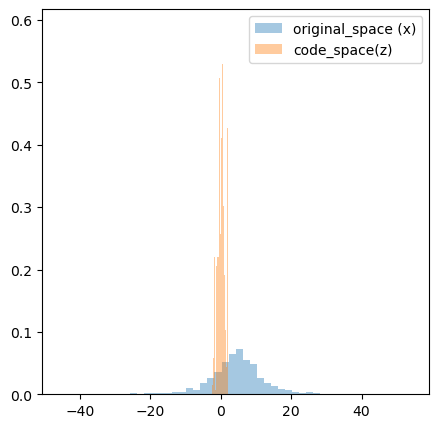

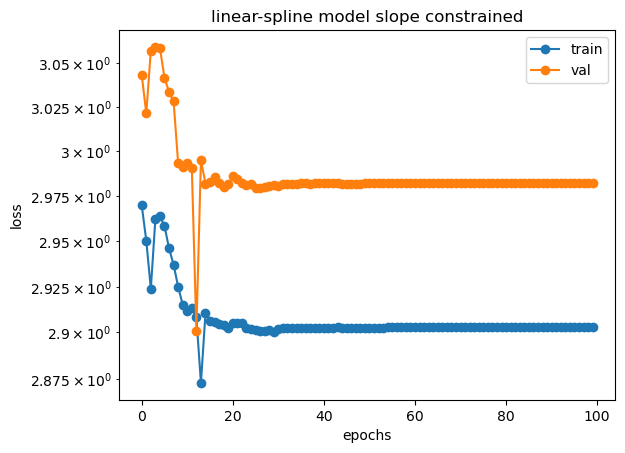

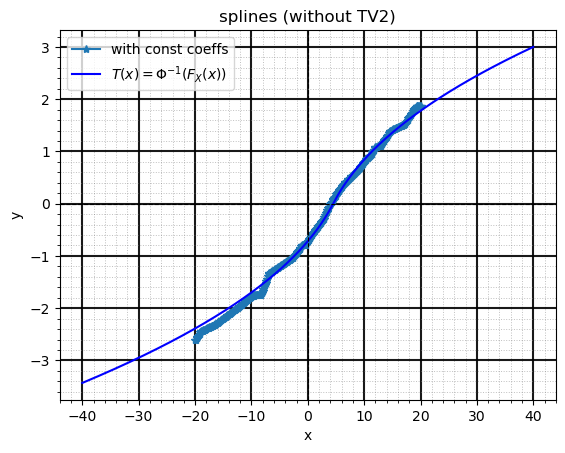

slopes: constrained coeffs: tensor([[0.0010, 0.0010, 0.1755, 0.1755, 0.1755, 0.1755, 0.1755, 0.1755, 0.1532,
         0.0495, 0.0495, 0.0495, 0.0495, 0.0495, 0.0495, 0.0495, 0.0495, 0.0495,
         0.0495, 0.0495, 0.0495, 0.0495, 0.0495, 0.0495, 0.0495, 0.0604, 0.0746,
         0.0750, 0.0780, 0.0781, 0.0785, 0.0791, 0.0795, 0.0795, 0.0796, 0.0796,
         0.0796, 0.0797, 0.0799, 0.0799, 0.0799, 0.0799, 0.0800, 0.0800, 0.0800,
         0.0801, 0.0801, 0.0801, 0.0801, 0.0802, 0.0803, 0.0803, 0.0804, 0.0806,
         0.0808, 0.0810, 0.0816, 0.0834, 0.0849, 0.0869, 0.0873, 0.0873, 0.0873,
         0.0873, 0.0873, 0.0873, 0.0873, 0.0873, 0.0873, 0.0873, 0.0873, 0.0873,
         0.0873, 0.0873, 0.0873, 0.0870, 0.0714, 0.0452, 0.0398, 0.0332, 0.0166,
         0.0016, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.2977,
         0.2977, 0.2977, 0.2977, 0.2977, 0.2977, 0.2977, 0.2977, 0.2977, 0.2977,
         0.1876, 0.0790, 0.0681, 0.0681, 0.0681, 0.0681, 0.0681, 0.0681, 0.0681,


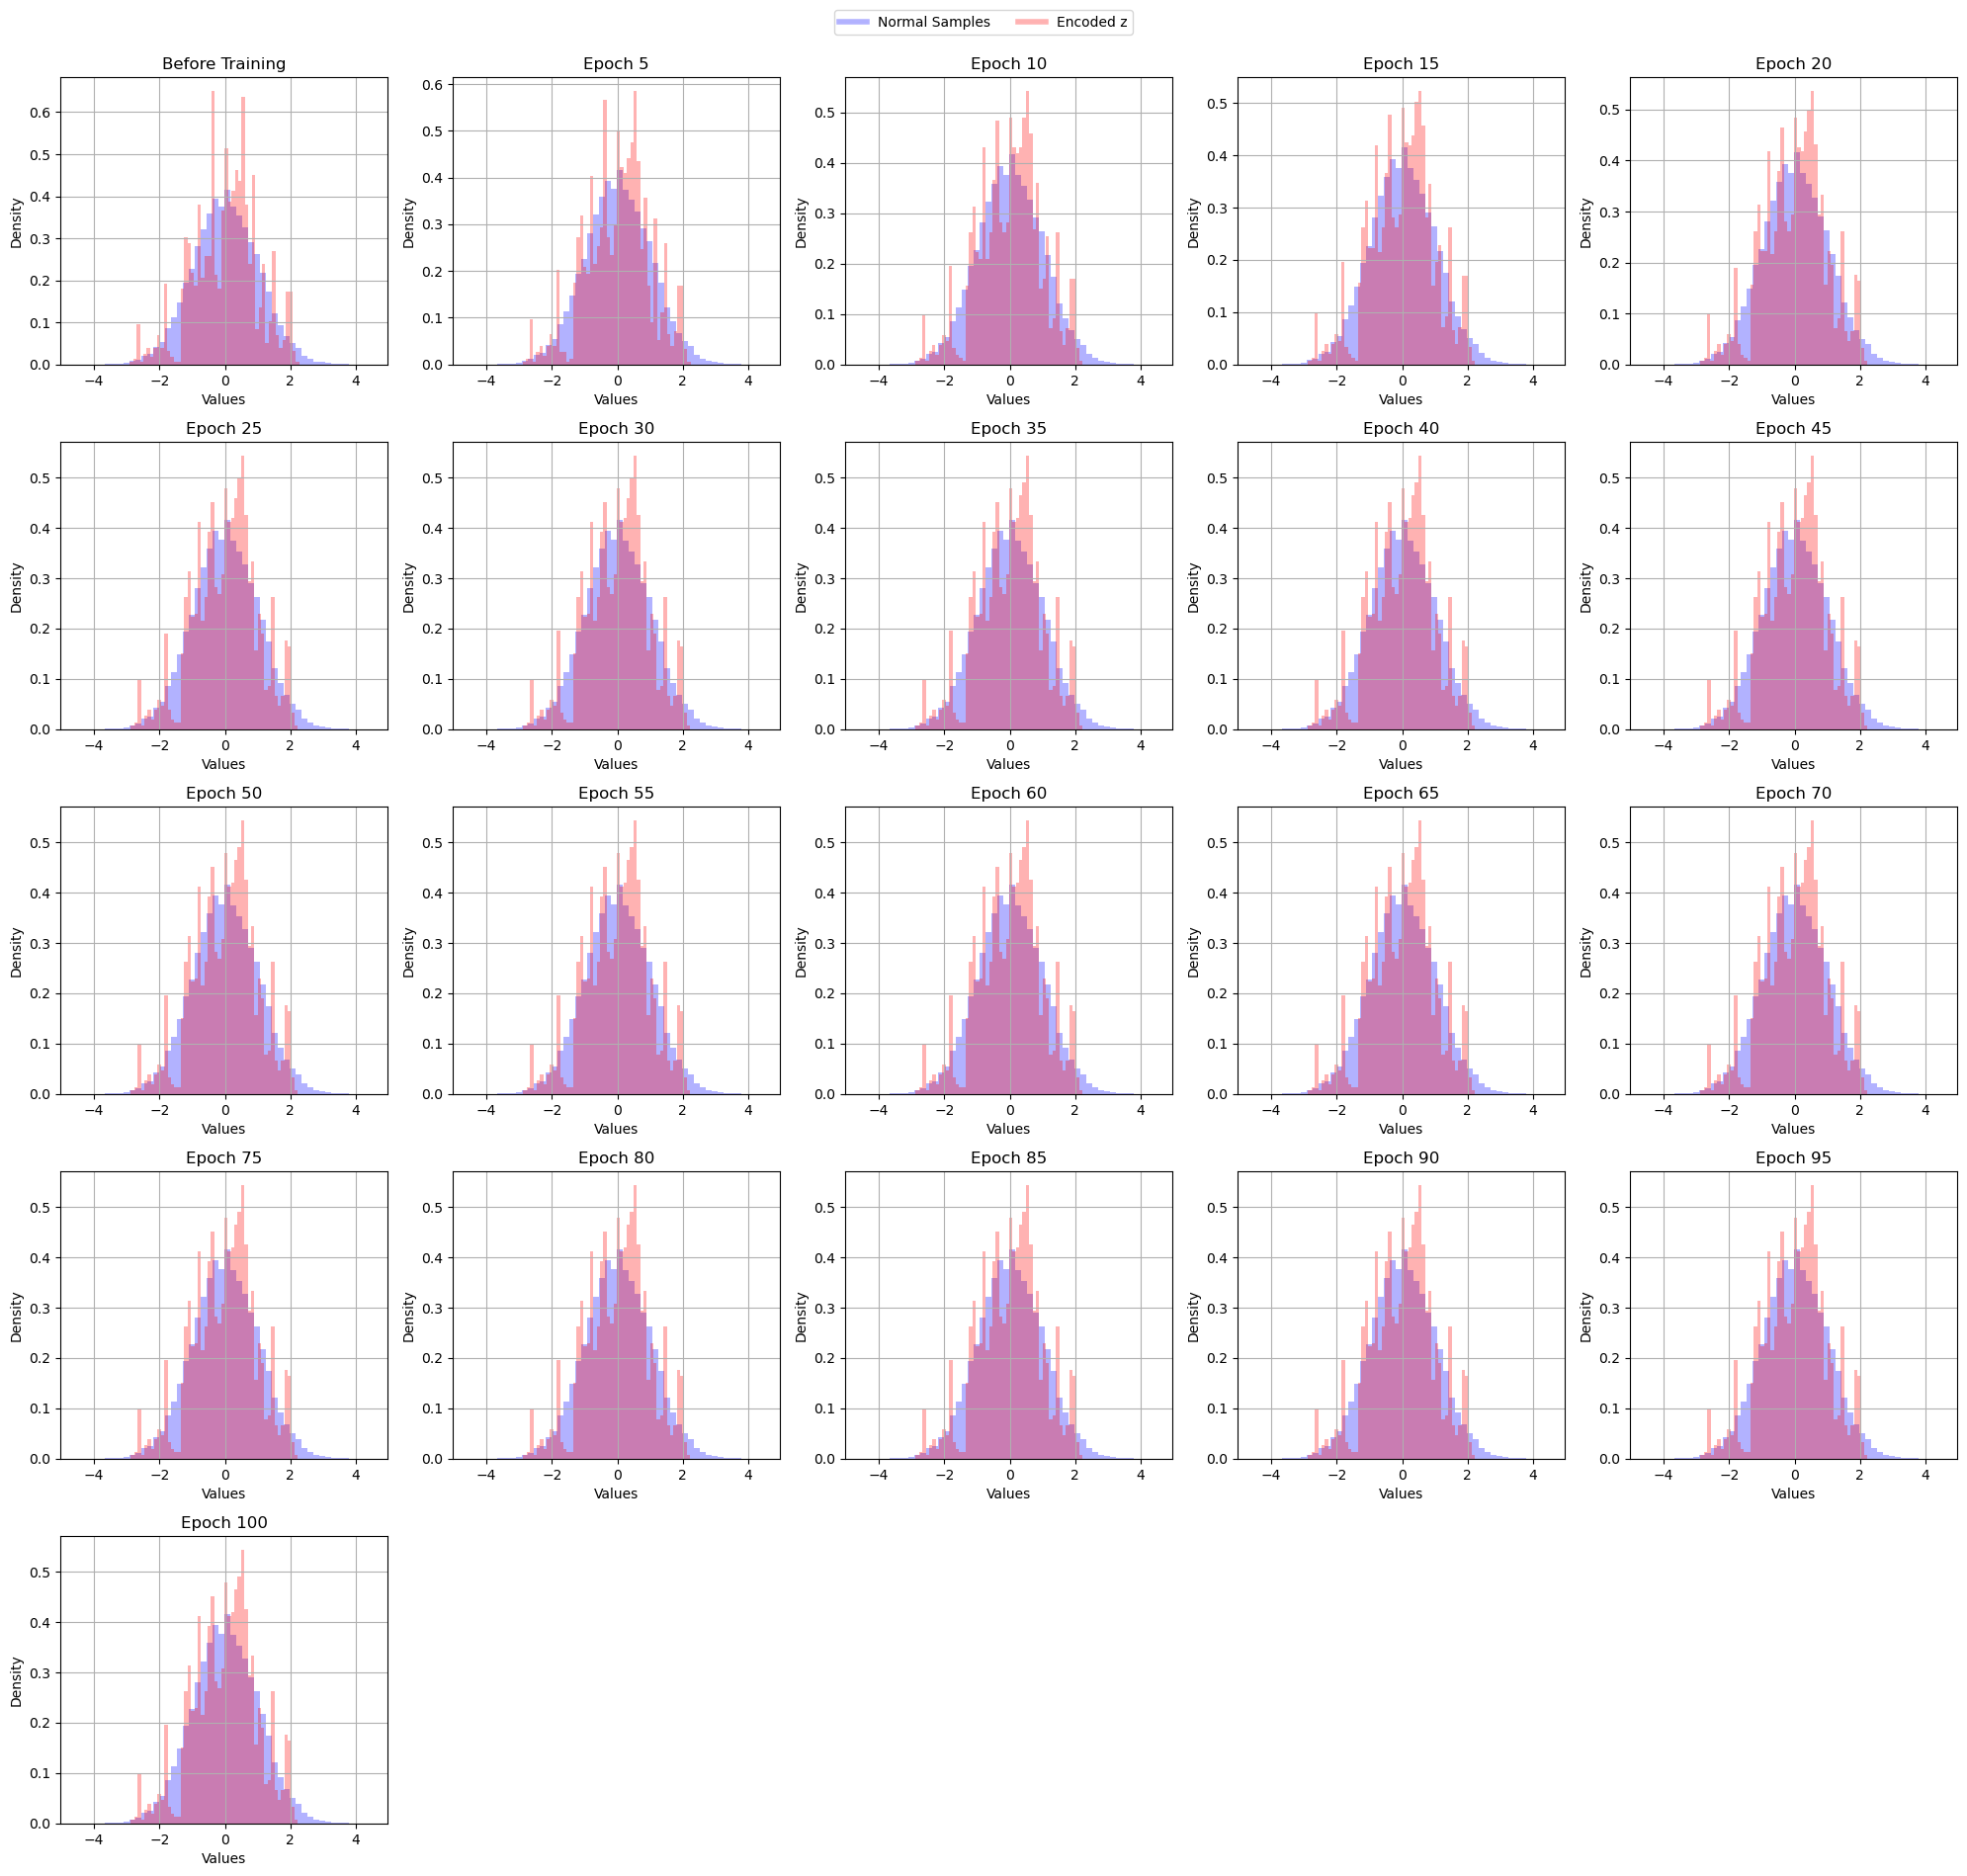

In [34]:
analyse_training(model_in=model2,
train_loss=train_loss2, val_loss=val_loss2, 
                test_data=test_data, figsize=(20,20),
                model_params_list=epoch_wise_param_list,
                num_coeffs=10,print_model_params=0, plot_freq=5) # 40 more (30 below+40 x3 below + 40  more= 70+40+40 + 40=110+40 +40=150+40=190)